# Visit With Us - Travel Package Prediction
## Summary
Visit With Us is a compnay that is looking to expand their customer base within the the Tourism Sector. They offer travel packages to customers and currently offer up 5 types:
1. Basic
2. Standard
3. Deluxe
4. Super Deluxe
5. King

The previous purchase rate they have experienced is approximately 18%. During the last campaign the randomly contacted customers wihtout targeting based on information about the customers. This time they are releasing a new product, a *Wellness Tourism Package*. This package is a travel package designed to help the customer kick-start a healthy lifestyle/support ones well-being. 

#### Purpose: Visit With Us wants to target advertising for their Wellness Tourism Package to potential customers as a way of increasing their customer base.

### Objectives:
 - Explore and clean the dataset of potential customers
 - Build a predictive model using Ensemble techniques to predict which customers are more likely to purchase the new travel package.
 
## Data Dictionary
1. CustomerID: Unique Customer Id
2. ProdTaken: Whether customer purchased a package {0:No, 1:Yes}
3. Age: Age of customer
4. TypeofContact: How customer was contacted [Company Invited, Self Inquiry]
5. CityTier: Development of a city, population, faciliites, and living standards [Tier 1 > Tier 2 > Tier 3]
6. Occupation: Customer occupation
7. Gender: Gender of customer
8. NumberOfPersonVisiting: Total number of persons taking the trip with the customer
9. PreferredPopertyStar: Prefferred hotel property rating
10. MaritalStatus: Marital status of customer
11. NumberOfTrips: Average number of trips in a year by customer
12. Passport: If customer has a passport {0:No, 1:Yes}
13. OwnCar: If customer owns a car {0:No, 1:Yes}
14. NumberOfChidrenVisiting: Total number of children with age less than 5 on trip
15. Designation: Designation of the customer in the current organization
16. MonthlyIncome: Gross monthly income of the customer
17. PitchSatisfactionScore: Sales pitch satisfaction score
18. ProductPitched: Product pitched by salesperson
19. NumberOfFollowups: Total number of follow-ups by sales person after sales pitch
20. DurationOfPitch: Duration of pitch by salesperson to customer


In [1]:
"""Packages imported for the analysis"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

sns.set_style("darkgrid")

import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')
from beepy import beep

%matplotlib inline

# Modeling Packaages
from sklearn import metrics
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier



## Data Exploration & Data Cleaning
### Initial assessment of the data

In [2]:
"""Import dataset and format into a basic dataframe"""
data = pd.read_excel("Tourism.xlsx", sheet_name='Tourism')
raw_df = data.copy()
del data

In [3]:
"""Initial assessment of data type, organization, and Nans"""
# The number of Nans within each feature
raw_df.isna().sum()

CustomerID                    0
ProdTaken                     0
Age                         226
TypeofContact                25
CityTier                      0
DurationOfPitch             251
Occupation                    0
Gender                        0
NumberOfPersonVisiting        0
NumberOfFollowups            45
ProductPitched                0
PreferredPropertyStar        26
MaritalStatus                 0
NumberOfTrips               140
Passport                      0
PitchSatisfactionScore        0
OwnCar                        0
NumberOfChildrenVisiting     66
Designation                   0
MonthlyIncome               233
dtype: int64

In [4]:
raw_df.isna().sum()[raw_df.isna().sum() > 0]

Age                         226
TypeofContact                25
DurationOfPitch             251
NumberOfFollowups            45
PreferredPropertyStar        26
NumberOfTrips               140
NumberOfChildrenVisiting     66
MonthlyIncome               233
dtype: int64

#### Notes
- **Age, TypeofContact, DurationOfPitch, NumberOfFollowups, PreferredPropertyStar, NumberOfTrips, NumberOfChildrenVisiting,** and **MonthlyIncome** all have Nan values which will have be addressed.

In [5]:
# The datatypes and counts (info) for the dataframe
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4888 entries, 0 to 4887
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CustomerID                4888 non-null   int64  
 1   ProdTaken                 4888 non-null   int64  
 2   Age                       4662 non-null   float64
 3   TypeofContact             4863 non-null   object 
 4   CityTier                  4888 non-null   int64  
 5   DurationOfPitch           4637 non-null   float64
 6   Occupation                4888 non-null   object 
 7   Gender                    4888 non-null   object 
 8   NumberOfPersonVisiting    4888 non-null   int64  
 9   NumberOfFollowups         4843 non-null   float64
 10  ProductPitched            4888 non-null   object 
 11  PreferredPropertyStar     4862 non-null   float64
 12  MaritalStatus             4888 non-null   object 
 13  NumberOfTrips             4748 non-null   float64
 14  Passport

In [6]:
num_cols = pd.Series(raw_df.select_dtypes(include=np.number).columns)
cat_cols = pd.Series(raw_df.select_dtypes(exclude=np.number).columns)

print(f"The numerical data is: \n{num_cols}")
print('*'*50)
print(f"The categorical data is: \n{cat_cols}")

The numerical data is: 
0                   CustomerID
1                    ProdTaken
2                          Age
3                     CityTier
4              DurationOfPitch
5       NumberOfPersonVisiting
6            NumberOfFollowups
7        PreferredPropertyStar
8                NumberOfTrips
9                     Passport
10      PitchSatisfactionScore
11                      OwnCar
12    NumberOfChildrenVisiting
13               MonthlyIncome
dtype: object
**************************************************
The categorical data is: 
0     TypeofContact
1        Occupation
2            Gender
3    ProductPitched
4     MaritalStatus
5       Designation
dtype: object


#### Notes
- **CustomerID** is numerical and likely is individual for each entry, may be substitute for index for the analysis. Will need to verify there are no duplicates.
- **ProdTaken, Passport,** and **OwnCar** are all numerical boolean features {0:No, 1:Yes}.
- All other numerical values are reasonable integer or float sequences of an actual count (such as number of trips) or sequential rank (such as CityTier). However, some of the floats should likely be integers, which whould be changed. The only true potential float variables should be **MontlyIncome** and **DurationOfPitch**. All other numerical data should be reported as integers.
- Categorical categories should not be an issue in and of themselves, but will need to be assessed for how many unique values each has to see if they need to be reduced before one-hot encoding.

In [7]:
# Examine sample rows of the actual data
raw_df.sample(7)

CustomerID  ProdTaken   Age    TypeofContact  CityTier  DurationOfPitch  \
2887      202887          1  23.0  Company Invited         1             11.0   
1423      201423          0   NaN     Self Enquiry         1              6.0   
1220      201220          0  36.0     Self Enquiry         3              NaN   
3420      203420          0  57.0     Self Enquiry         1             30.0   
3974      203974          0  33.0     Self Enquiry         1              7.0   
1221      201221          0  45.0  Company Invited         1              6.0   
1981      201981          0  36.0     Self Enquiry         1             15.0   

          Occupation  Gender  NumberOfPersonVisiting  NumberOfFollowups  \
2887  Large Business    Male                       3                5.0   
1423        Salaried    Male                       3                3.0   
1220        Salaried  Female                       2                3.0   
3420        Salaried    Male                       4                4.0   
3974  Small Business    Male                       3                4.0   
1221        Salaried    Male                       3                4.0   
1981  Small Business    Male                       2                4.0   

     ProductPitched  PreferredPropertyStar MaritalStatus  NumberOfTrips  \
2887          Basic                    3.0     Unmarried            7.0   
1423          Basic                    3.0        Single            1.0   
1220         Deluxe                    3.0        Single            4.0   
3420   Super Deluxe                    4.0      Divorced            6.0   
3974         Deluxe                    3.0       Married            3.0   
1221       Standard                    3.0       Married            4.0   
1981         Deluxe                    4.0       Married            3.0   

      Passport  PitchSatisfactionScore  OwnCar  NumberOfChildrenVisiting  \
2887         0                       5       1                       1.0   
1423         0                       3       0                       2.0   
1220         0                       4       1                       1.0   
3420         1                       4       1                       3.0   
3974         1                       4       1                       2.0   
1221         0                       1       1                       2.0   
1981         1                       4       0                       1.0   

         Designation  MonthlyIncome  
2887       Executive        22572.0  
1423       Executive        18375.0  
1220         Manager        19502.0  
3420             AVP        32080.0  
3974         Manager        24840.0  
1221  Senior Manager        25748.0  
1981         Manager        23847.0

In [8]:
# Check for duplicate rows and check on shape
print(f"There are {raw_df.duplicated().sum()} duplicate data entries.")
raw_df.shape

There are 0 duplicate data entries.


(4888, 20)

In [9]:
# Assess number of unique values in for each numerical feature
for i in num_cols:
    print(f"The number of unique values in {i} are: {raw_df[i].nunique()}")

The number of unique values in CustomerID are: 4888
The number of unique values in ProdTaken are: 2
The number of unique values in Age are: 44
The number of unique values in CityTier are: 3
The number of unique values in DurationOfPitch are: 34
The number of unique values in NumberOfPersonVisiting are: 5
The number of unique values in NumberOfFollowups are: 6
The number of unique values in PreferredPropertyStar are: 3
The number of unique values in NumberOfTrips are: 12
The number of unique values in Passport are: 2
The number of unique values in PitchSatisfactionScore are: 5
The number of unique values in OwnCar are: 2
The number of unique values in NumberOfChildrenVisiting are: 4
The number of unique values in MonthlyIncome are: 2475


In [10]:
# Assess number of unique values in for each categorical feature
for i in cat_cols:
    print(f"The number of unique values in {i} are: {raw_df[i].nunique()}")

The number of unique values in TypeofContact are: 2
The number of unique values in Occupation are: 4
The number of unique values in Gender are: 3
The number of unique values in ProductPitched are: 5
The number of unique values in MaritalStatus are: 4
The number of unique values in Designation are: 5


#### Notes
- **CustomerID** is a unique identifier as there are no duplicates and 4888 unique values. This feature may be set as the index.
- All categorical values should not cause major issues with regards to one-hot encoding. No categorical features have more than 5 differnt categories. 

### Basic Cleaning steps:
- Exmaine and solve Nans in Age,TypeofContact, DurationOfPitch, NumberOfFollowups, PreferredPropertyStar, NumberOfTrips, NumberOfChildrenVisiting, and MonthlyIncome.
- Examine the data for incorrect data entry
- Check on and set floats that are more appropriately integer variables to be integers.
- Set categorical variables to be categorical within the dataframe.

In [11]:
"""Solve Nans within the dataset and organize it for more thorough EDA"""
df_clean = raw_df.copy()
del raw_df

In [12]:
df_clean.isna().sum()[df_clean.isna().sum() > 0]

Age                         226
TypeofContact                25
DurationOfPitch             251
NumberOfFollowups            45
PreferredPropertyStar        26
NumberOfTrips               140
NumberOfChildrenVisiting     66
MonthlyIncome               233
dtype: int64

<AxesSubplot:>

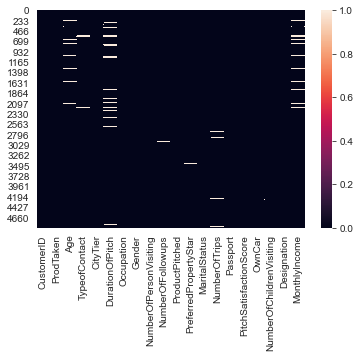

In [13]:
sns.heatmap(df_clean.isna())

There are not strong patterns of the Nan valueswithin the data. Therefore each feature will likely need to be assessed individually.

In [14]:
"""Percent of Nans for each feature are all low"""
df_clean.isna().sum()[df_clean.isna().sum() > 0]/df_clean.shape[0] * 100

Age                         4.623568
TypeofContact               0.511457
DurationOfPitch             5.135025
NumberOfFollowups           0.920622
PreferredPropertyStar       0.531915
NumberOfTrips               2.864157
NumberOfChildrenVisiting    1.350245
MonthlyIncome               4.766776
dtype: float64

Interpolation is unlikely to greatly influence any of the features since none have a proportion of Nans significantly over 5% of the data entries. **Will need to check if there are correlations that could be used to interpolate based on relationships to other related features or if median and mode are the best routes.**

**TypeofContact** is the only categorical variable, all the others are numerical that have Nans.

<AxesSubplot:>

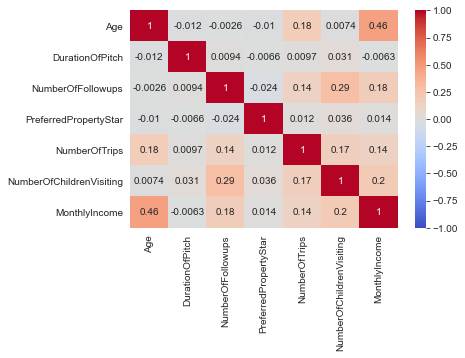

In [15]:
"""Heatmap of Pearson Correlations for only numerical features with Nans"""
nan_cols = df_clean.isna().sum()[df_clean.isna().sum() > 0].index.tolist()
nan_cols.remove('TypeofContact')
sns.heatmap(df_clean[nan_cols].corr(), vmin=-1, vmax=1, cmap='coolwarm', annot=True)

There are no major linear relationships preset within the data. The highest is a 0.46 realationship between Age and MonthlyIncome, which could be worth assessing more carefully.

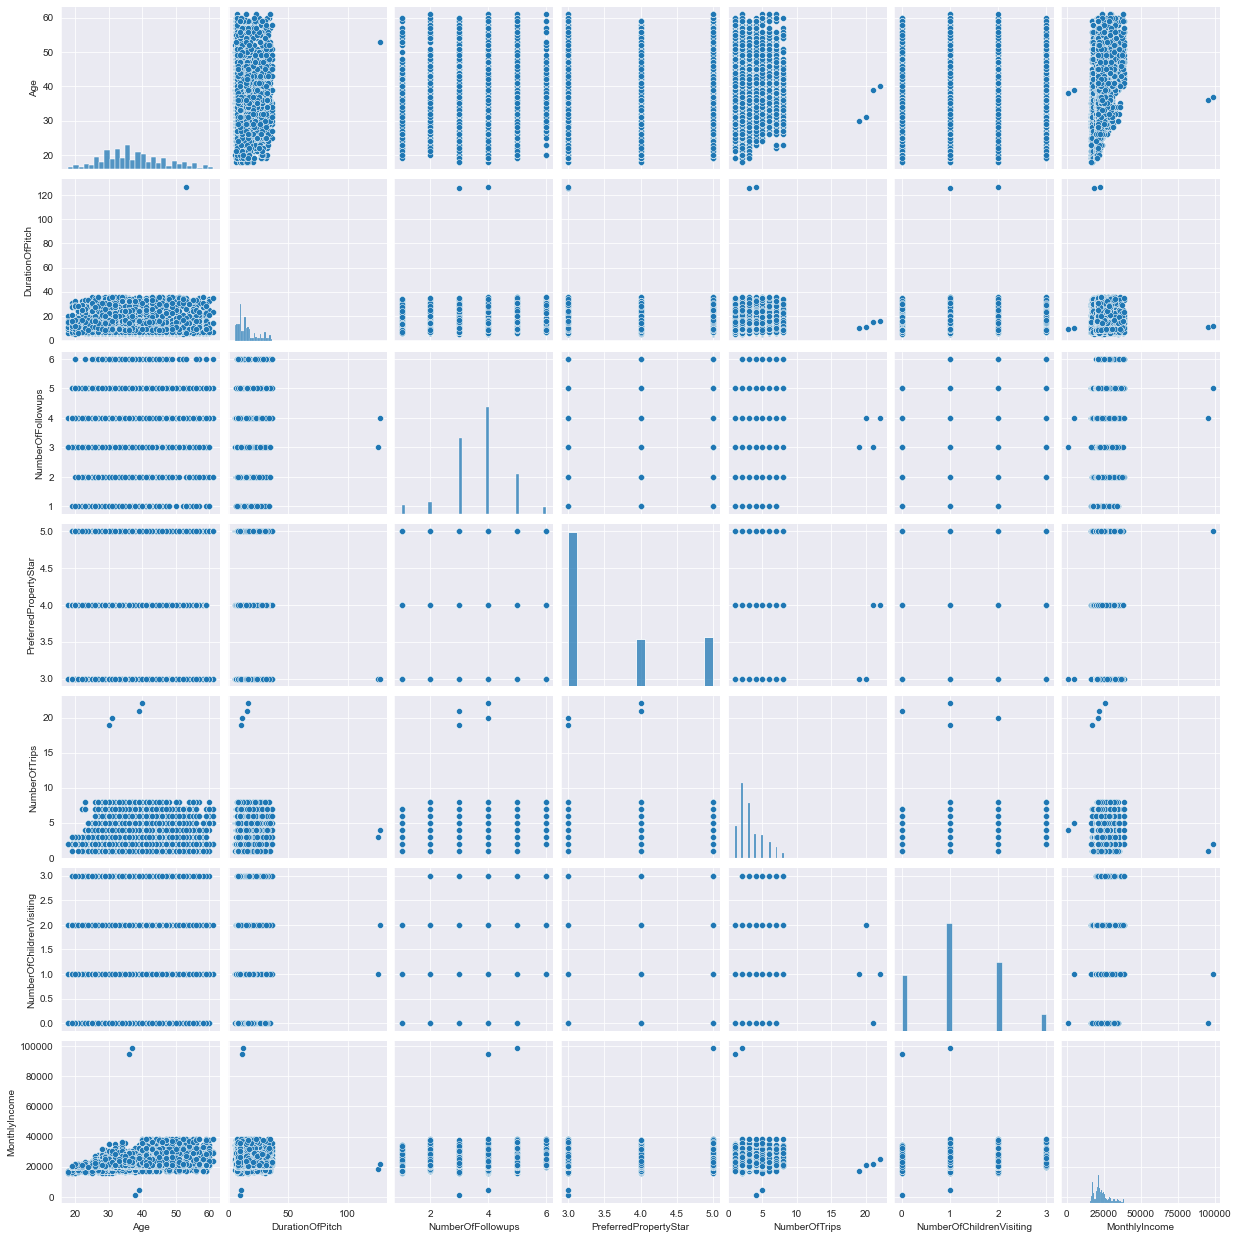

In [16]:
sns.pairplot(df_clean[nan_cols])

<AxesSubplot:xlabel='Age', ylabel='MonthlyIncome'>

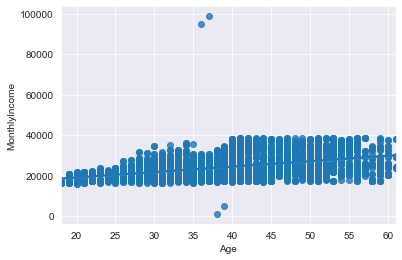

In [17]:
sns.regplot(data=df_clean, x = "Age", y = "MonthlyIncome")

There are no major correlations in the numerical columns with Nans. There is a very slight one between Age and Monthly Income, but nothing likely to help dramatically with interpreting Nans.

#### Nans will be substituted for the median and mode of the columns depending on whethe the data is numerical or categorical.



In [18]:
#Replace all Nans in numerical columns with the median of that column
for i in range(len(nan_cols)):
    x = df_clean[nan_cols[i]].median()
    df_clean[nan_cols[i]].fillna(x, inplace=True)
    
x = df_clean.TypeofContact.value_counts().index[0]
df_clean.TypeofContact.fillna(x, inplace=True)


<AxesSubplot:>

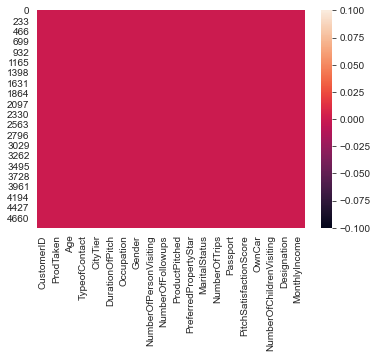

In [19]:
sns.heatmap(df_clean.isna())

#### All NaNs have been removed from the dataset

### Examination for discrepancies in data entry

In [20]:
df_clean.describe(include=np.number)

CustomerID    ProdTaken          Age     CityTier  DurationOfPitch  \
count    4888.000000  4888.000000  4888.000000  4888.000000      4888.000000   
mean   202443.500000     0.188216    37.547259     1.654255        15.362930   
std      1411.188388     0.390925     9.104795     0.916583         8.316166   
min    200000.000000     0.000000    18.000000     1.000000         5.000000   
25%    201221.750000     0.000000    31.000000     1.000000         9.000000   
50%    202443.500000     0.000000    36.000000     1.000000        13.000000   
75%    203665.250000     0.000000    43.000000     3.000000        19.000000   
max    204887.000000     1.000000    61.000000     3.000000       127.000000   

       NumberOfPersonVisiting  NumberOfFollowups  PreferredPropertyStar  \
count             4888.000000        4888.000000            4888.000000   
mean                 2.905074           3.711129               3.577946   
std                  0.724891           0.998271               0.797005   
min                  1.000000           1.000000               3.000000   
25%                  2.000000           3.000000               3.000000   
50%                  3.000000           4.000000               3.000000   
75%                  3.000000           4.000000               4.000000   
max                  5.000000           6.000000               5.000000   

       NumberOfTrips     Passport  PitchSatisfactionScore       OwnCar  \
count    4888.000000  4888.000000             4888.000000  4888.000000   
mean        3.229746     0.290917                3.078151     0.620295   
std         1.822769     0.454232                1.365792     0.485363   
min         1.000000     0.000000                1.000000     0.000000   
25%         2.000000     0.000000                2.000000     0.000000   
50%         3.000000     0.000000                3.000000     1.000000   
75%         4.000000     1.000000                4.000000     1.000000   
max        22.000000     1.000000                5.000000     1.000000   

       NumberOfChildrenVisiting  MonthlyIncome  
count               4888.000000    4888.000000  
mean                   1.184738   23559.179419  
std                    0.852323    5257.862921  
min                    0.000000    1000.000000  
25%                    1.000000   20485.000000  
50%                    1.000000   22347.000000  
75%                    2.000000   25424.750000  
max                    3.000000   98678.000000

#### Notes:
- There is minumum **MonthlyIncome** of \\$1,000, this is not only an outlier, but likely an error. Not only is a \\$1,000 a month salary exheedingly low, it's highly unlikely when it comes to a customer purchasing an expensive vacation package. These entries will need to be examined more closely. It also does have some very high monthly income reported, which is close to \\$100,000 a month and while these are likely outliers, they are less likely to be a data entry error.
- **NumberOfTrips** has a max dramatically above the others. Perhaps this is a typo as 2 seems to be more common number and the value is specifically 22. Will need to be examined more closely.
- **DurationOfPitch** has a dramtically high max that also could be in error, or is at least due to severe outliers.

In [21]:
def hist_boxplot(df, feature, figsize=(12, 7), kde=False):
    """
    Boxplot and histogram plotted on same axes for easy comparison
    for a single variable.
    
    df: dataframe for data
    feature: column of interest
    figsize: size of figure
    kde: whether to plot the kde for the histogram
    bins: number of bins for the histogram
    """
    fig, (ax_box2, ax_hist2) = plt.subplots(nrows=2, sharex=True,
                                           gridspec_kw={'height_ratios': (0.25, 0.75)},
                                           figsize=figsize)
    sns.boxplot(data=df, x=feature, ax=ax_box2, showmeans=True)
    sns.histplot(data=df, x=feature, kde=kde, ax=ax_hist2)
    ax_hist2.axvline(df[feature].median(), color='black', linestyle='-')
    ax_hist2.axvline(df[feature].mean(), color='green', linestyle='--')

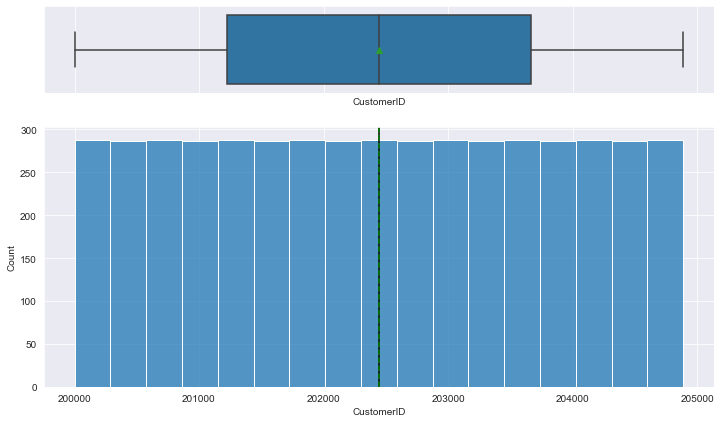

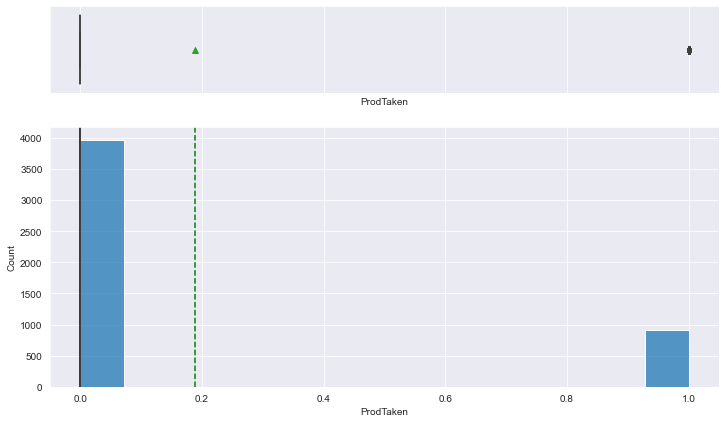

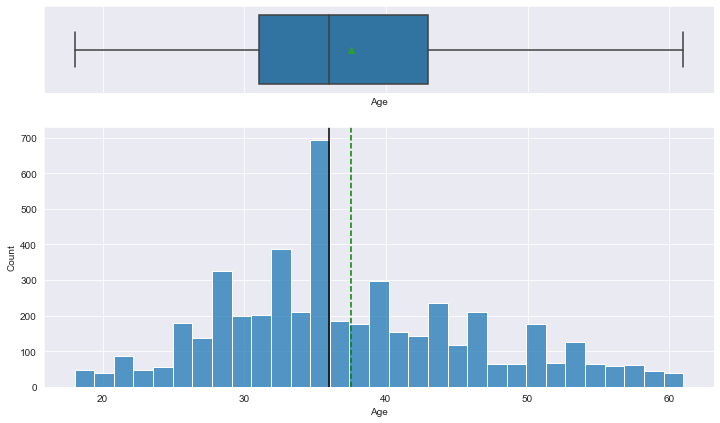

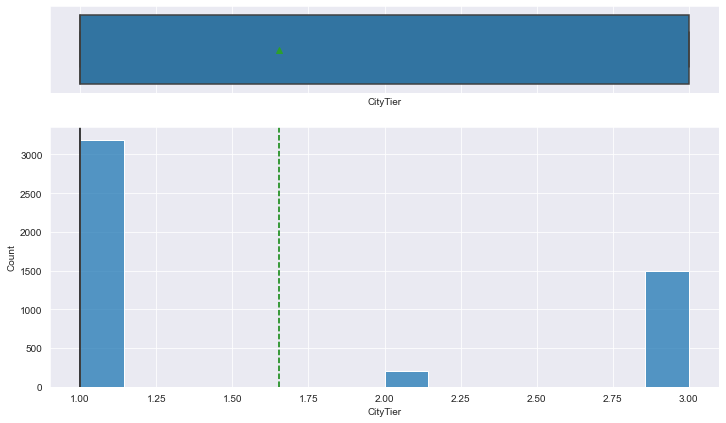

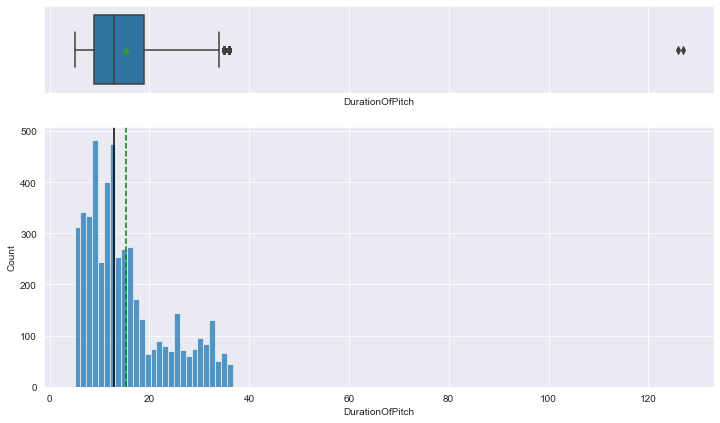

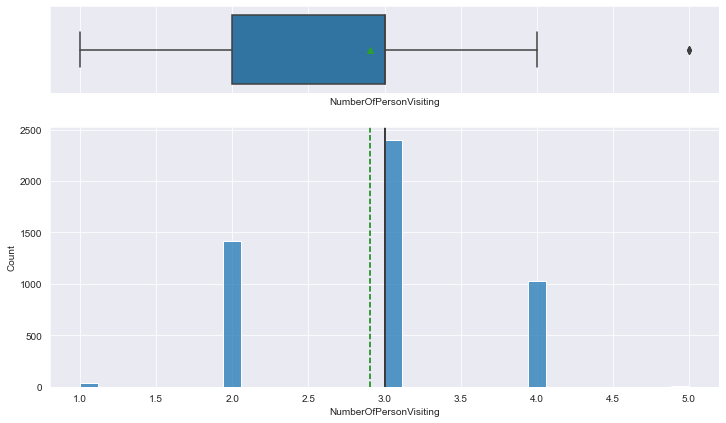

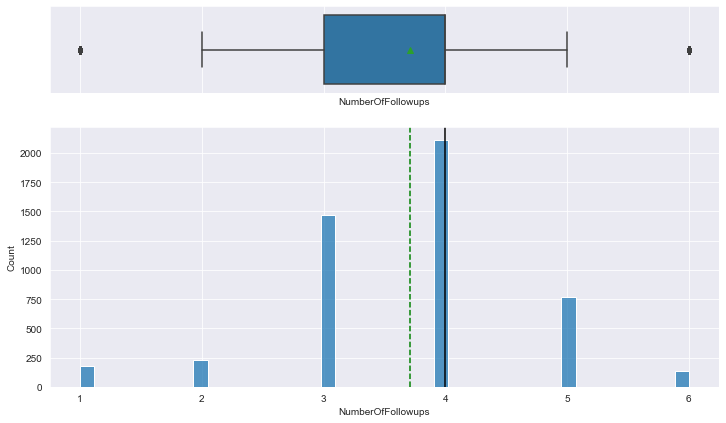

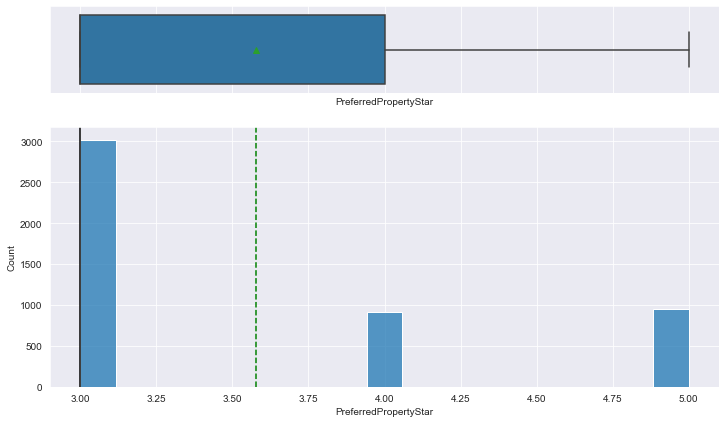

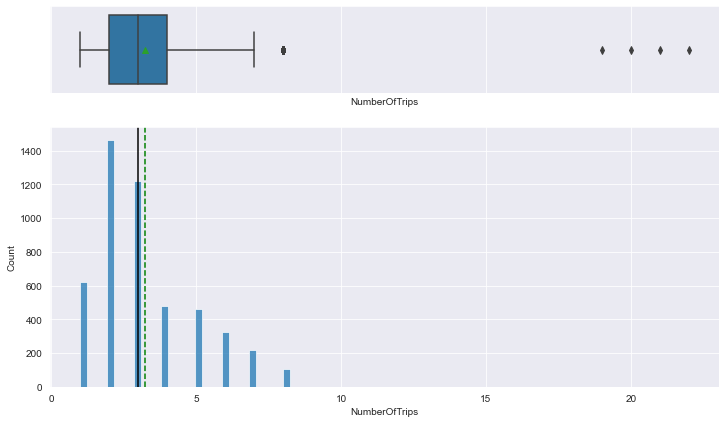

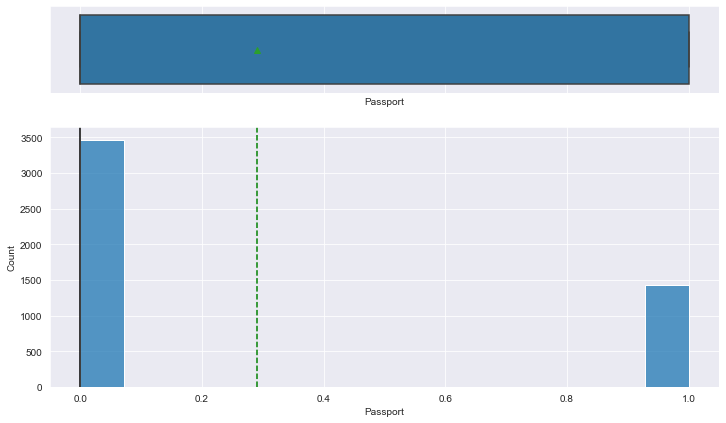

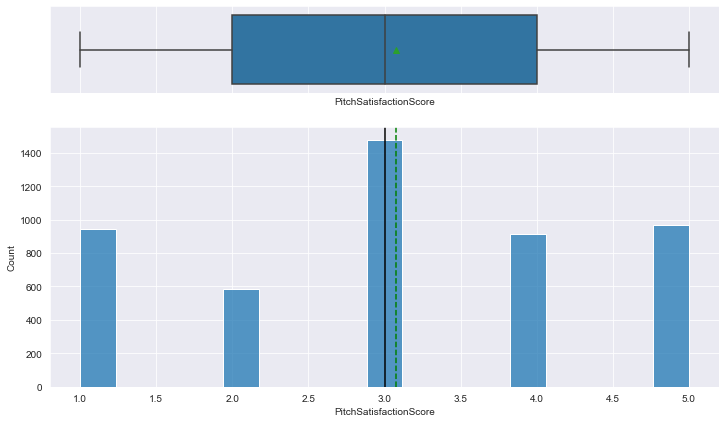

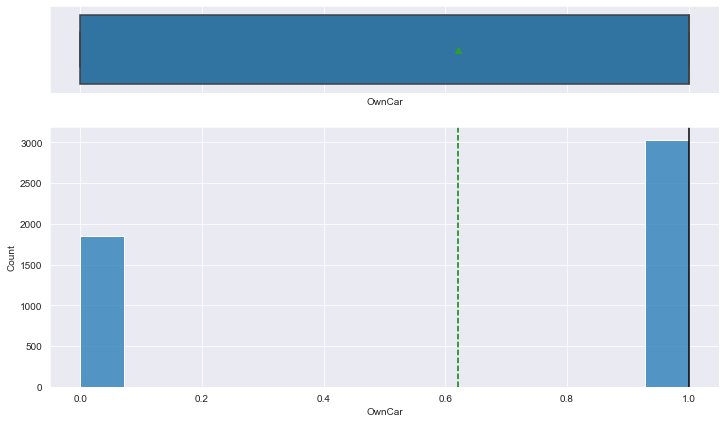

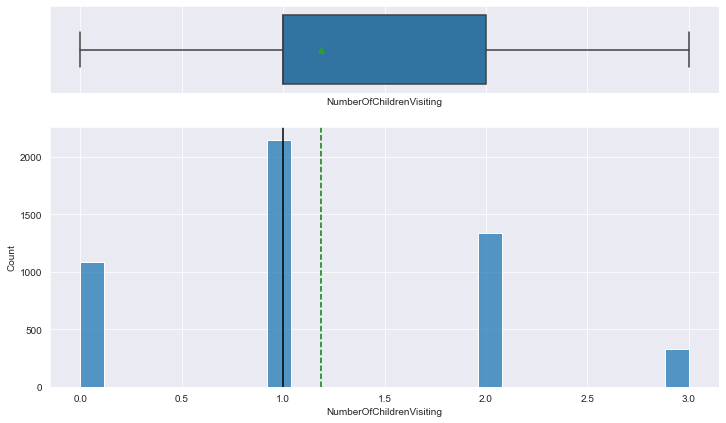

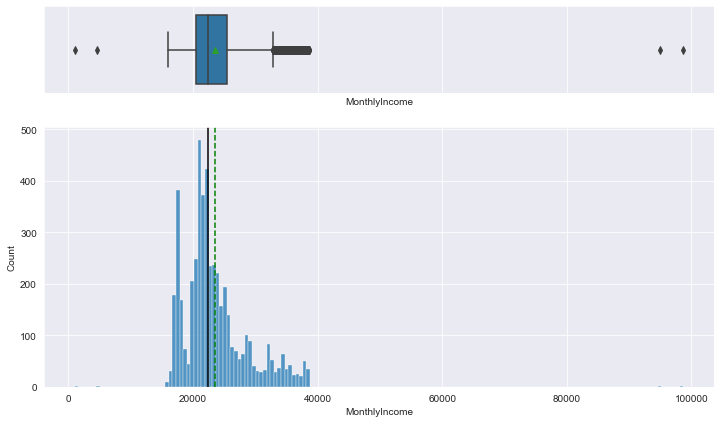

In [22]:
"""Closer examination of numerical features with boxplot and histograms"""
num_cols = df_clean.select_dtypes(include=np.number).columns.tolist()
for i in range(len(num_cols)):
    hist_boxplot(df_clean, num_cols[i])

#### Notes:
- **DurationOfPitch** has significant outliers, at least two are not far beyond the uppper quartile and likely not a problem. However, at least two ptiches come in at over 2 hours! None of the others are over 40 minutes.These are major significant outliers that will need to be dealt with, but also could simply be data entry errors and will need to be examined more closely. For instance, perhaps they are supposed to be 12 minute pitches? That would actually put them around the median length for pitch. 
- **NumberOfTrips** does have a small group of outliers all around 20 (only ones greater than 15). These are clearly outliers, but due to some variation are unlikely as simple as a keystroke error.
- **MonthlyIncome** Does have outliers on both the low and high ends. A closer examination of the lower ones is certainly called for, especially the flat monthly income of \\$1,000. There is at least one more that is also less than \\$10,000. However, there are a small number of very high outliers as well that need to be addressed. They appear to be the only ones greater than \\$80,000.

In [23]:
# Examine Duration of Pitch outlier entries
df_clean[df_clean.DurationOfPitch > 40]

CustomerID  ProdTaken   Age    TypeofContact  CityTier  DurationOfPitch  \
1434      201434          0  36.0  Company Invited         3            126.0   
3878      203878          0  53.0  Company Invited         3            127.0   

     Occupation Gender  NumberOfPersonVisiting  NumberOfFollowups  \
1434   Salaried   Male                       2                3.0   
3878   Salaried   Male                       3                4.0   

     ProductPitched  PreferredPropertyStar MaritalStatus  NumberOfTrips  \
1434          Basic                    3.0       Married            3.0   
3878          Basic                    3.0       Married            4.0   

      Passport  PitchSatisfactionScore  OwnCar  NumberOfChildrenVisiting  \
1434         0                       1       1                       1.0   
3878         0                       1       1                       2.0   

     Designation  MonthlyIncome  
1434   Executive        18482.0  
3878   Executive        22160.0

In [24]:
# Examine Number of Trips outlier entries
df_clean[df_clean.NumberOfTrips > 15]

CustomerID  ProdTaken   Age    TypeofContact  CityTier  DurationOfPitch  \
385       200385          1  30.0  Company Invited         1             10.0   
816       200816          0  39.0  Company Invited         1             15.0   
2829      202829          1  31.0  Company Invited         1             11.0   
3260      203260          0  40.0  Company Invited         1             16.0   

          Occupation Gender  NumberOfPersonVisiting  NumberOfFollowups  \
385   Large Business   Male                       2                3.0   
816         Salaried   Male                       3                3.0   
2829  Large Business   Male                       3                4.0   
3260        Salaried   Male                       4                4.0   

     ProductPitched  PreferredPropertyStar MaritalStatus  NumberOfTrips  \
385           Basic                    3.0        Single           19.0   
816          Deluxe                    4.0     Unmarried           21.0   
2829          Basic                    3.0        Single           20.0   
3260         Deluxe                    4.0     Unmarried           22.0   

      Passport  PitchSatisfactionScore  OwnCar  NumberOfChildrenVisiting  \
385          1                       4       1                       1.0   
816          0                       2       1                       0.0   
2829         1                       4       1                       2.0   
3260         0                       2       1                       1.0   

     Designation  MonthlyIncome  
385    Executive        17285.0  
816      Manager        21782.0  
2829   Executive        20963.0  
3260     Manager        25460.0

In [25]:
# Examine Monthly Income low outlier entries
df_clean[df_clean.MonthlyIncome < 10000]

CustomerID  ProdTaken   Age TypeofContact  CityTier  DurationOfPitch  \
142       200142          0  38.0  Self Enquiry         1              9.0   
2586      202586          0  39.0  Self Enquiry         1             10.0   

          Occupation  Gender  NumberOfPersonVisiting  NumberOfFollowups  \
142   Large Business  Female                       2                3.0   
2586  Large Business  Female                       3                4.0   

     ProductPitched  PreferredPropertyStar MaritalStatus  NumberOfTrips  \
142          Deluxe                    3.0        Single            4.0   
2586         Deluxe                    3.0        Single            5.0   

      Passport  PitchSatisfactionScore  OwnCar  NumberOfChildrenVisiting  \
142          1                       5       0                       0.0   
2586         1                       5       0                       1.0   

     Designation  MonthlyIncome  
142      Manager         1000.0  
2586     Manager         4678.0

In [26]:
# Examine Monthly Income high outlier entries
df_clean[df_clean.MonthlyIncome > 80000]

CustomerID  ProdTaken   Age TypeofContact  CityTier  DurationOfPitch  \
38        200038          0  36.0  Self Enquiry         1             11.0   
2482      202482          0  37.0  Self Enquiry         1             12.0   

     Occupation  Gender  NumberOfPersonVisiting  NumberOfFollowups  \
38     Salaried  Female                       2                4.0   
2482   Salaried  Female                       3                5.0   

     ProductPitched  PreferredPropertyStar MaritalStatus  NumberOfTrips  \
38            Basic                    3.0      Divorced            1.0   
2482          Basic                    5.0      Divorced            2.0   

      Passport  PitchSatisfactionScore  OwnCar  NumberOfChildrenVisiting  \
38           1                       2       1                       0.0   
2482         1                       2       1                       1.0   

     Designation  MonthlyIncome  
38     Executive        95000.0  
2482   Executive        98678.0

#### Notes
- None of the outliers across the variables are the same data entry.
- **DurationOfPitch** outliers do not appear to be keystroke errors, and simply may be very long over two hour pitchs. Perhaps this was done over a meal? Regardless, they are major outliers. *They will be converted to the upper quartile value of the dataset to prevent a large bias in the dataset from those two points, but leave them as a slight weight to higher values due to no clear evidence the values are in error. The other outliers are close enough to distribution of pitch times they will be left as is.*
- **NumberOfTrips** has 4 major outliers, all of which have 19 or greater as their average number of trips per year. There is no clear evidence these entries are in error, despite how hard it is to believe around 20 trips a year. There is no information about the trips, so perhaps there are a number of weekend trips. *As a result these will be converted to the upper quartile value to add a slight upper weight to the distribution, but not too great for such a few entries.*
- **MonthlyIncome** one entry of the lower outliers has an income of \\$4,678, which not only is a detailed value, but not an unreasonable monthly salary. *This value will be kept unchanged as it is not dramitically far from the rest of the distrubtion and appears to be a true value.* The other outlier is simply $1,000. This is odd in that it is a flat value and a very low value for monthly income. *This value will be converted to the median **MonthlyIncome** so as not to influence the dataset as it seems likely this is an error of some form.*
- On the higher outliers of **MonthlyIncome** we have one which appears to be valid at \\$98,678. The value is high, but due to the detail of the value is unlikely an error. The second, is simply \\$95,000. The flat value here is suspicious, but the income while high is not impossible and the other value suggests can occur, they also are an Executive by designation (both of these customers are). *Without better information, both of these outliers will be converted to the upper quartile of **Monthly Income**. This will maintain some level of higher weighting on the distribution due to these individuals, but not overly influence the distrubution based on only these two.*


In [27]:
"""Solve outliers found in numerical data"""
# DurationOfPitch
Q3 = df_clean.DurationOfPitch.quantile(q=0.75) # Find value of upper quartile
df_clean.DurationOfPitch[df_clean.DurationOfPitch > 40] = Q3 # Replace values with the value of the upper quartile

# NumberOfTrips
Q3 = df_clean.NumberOfTrips.quantile(q=0.75) # Find value of upper quartile
df_clean.NumberOfTrips[df_clean.NumberOfTrips > 15] = Q3 # Replace values with the value of the upper quartile

# MonthlyIncome
Q2 = df_clean.MonthlyIncome.median() # Find value of the median
Q3 = df_clean.MonthlyIncome.quantile(q=0.75) # Find value of upper quartile
df_clean.MonthlyIncome[df_clean.MonthlyIncome == 1000] = Q2 # Replace low outlier value with the median
df_clean.MonthlyIncome[df_clean.MonthlyIncome > 80000] = Q3 # Replace low outlier value with the upper quartile


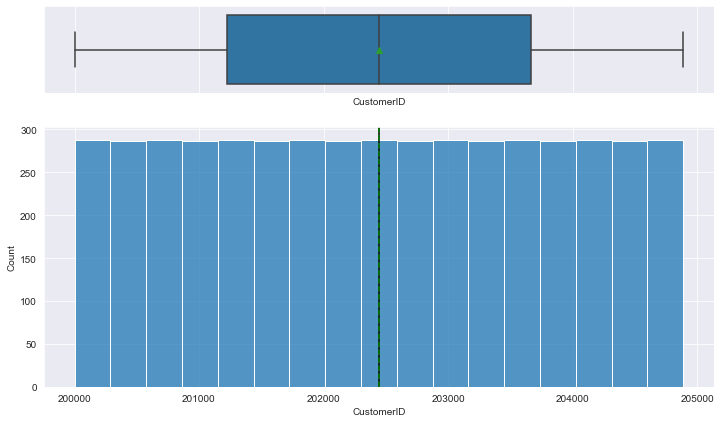

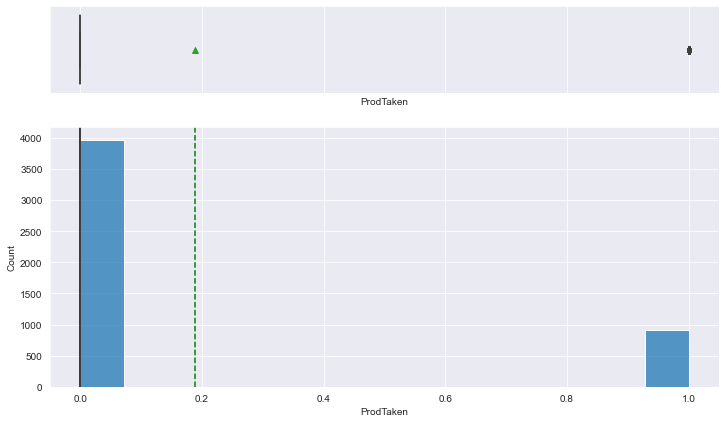

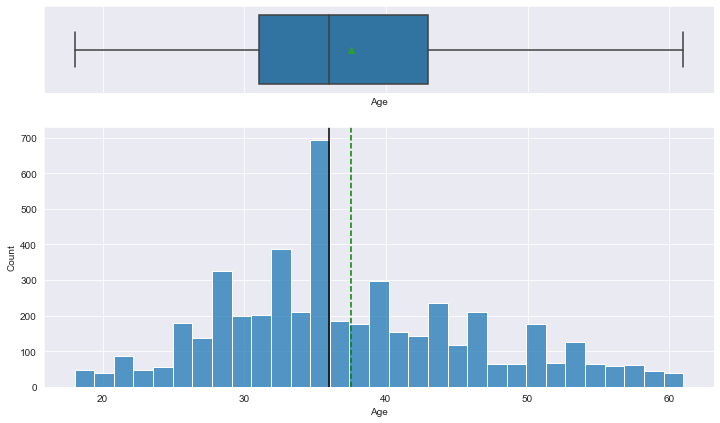

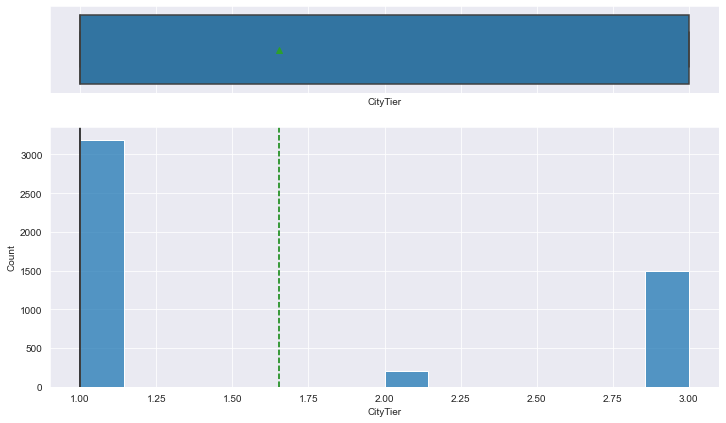

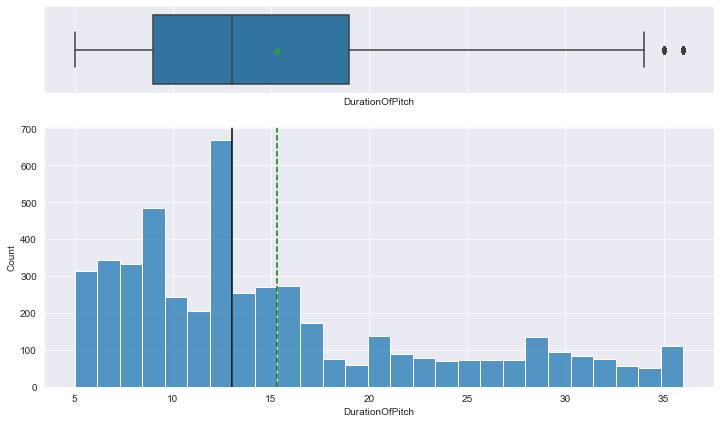

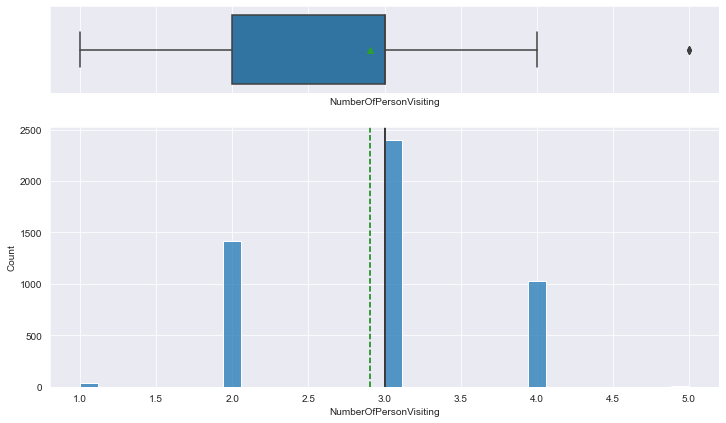

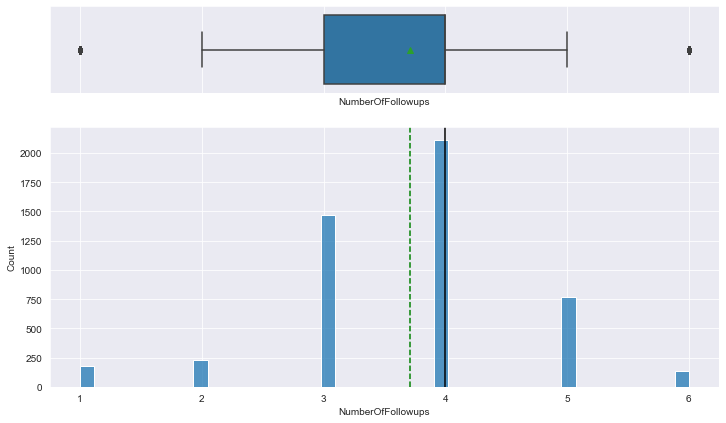

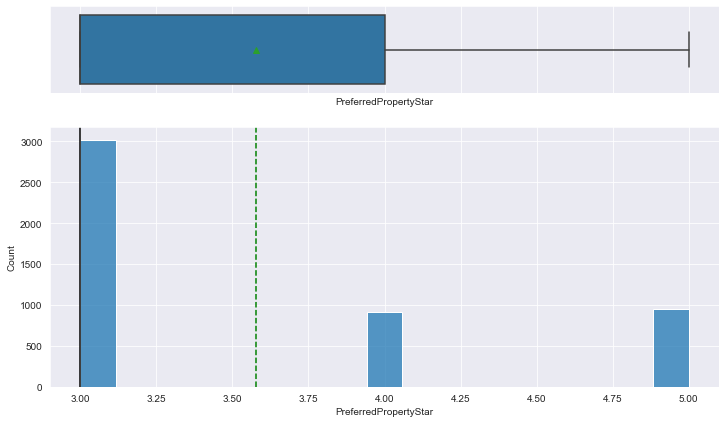

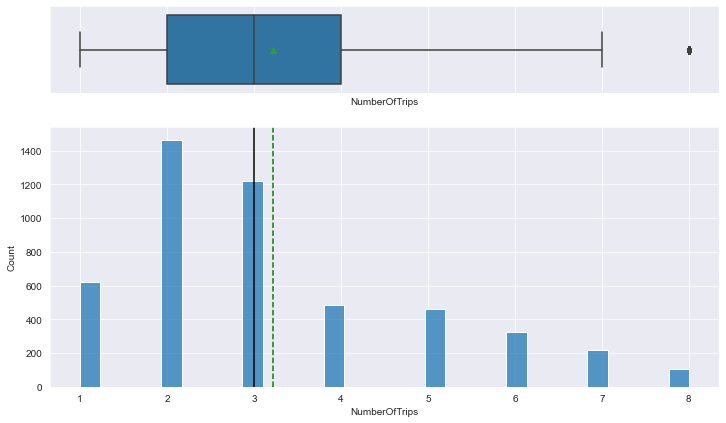

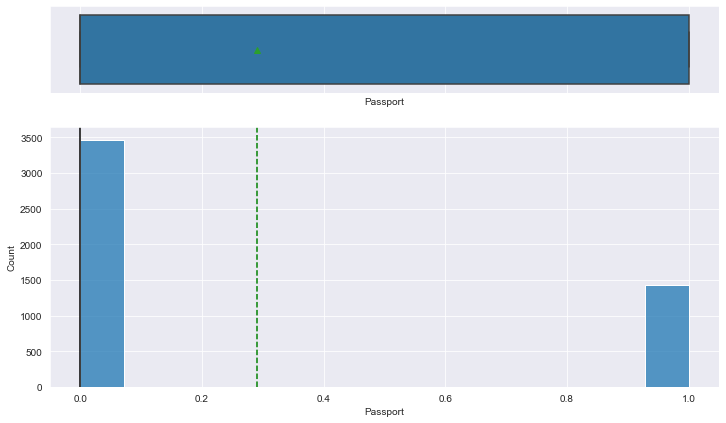

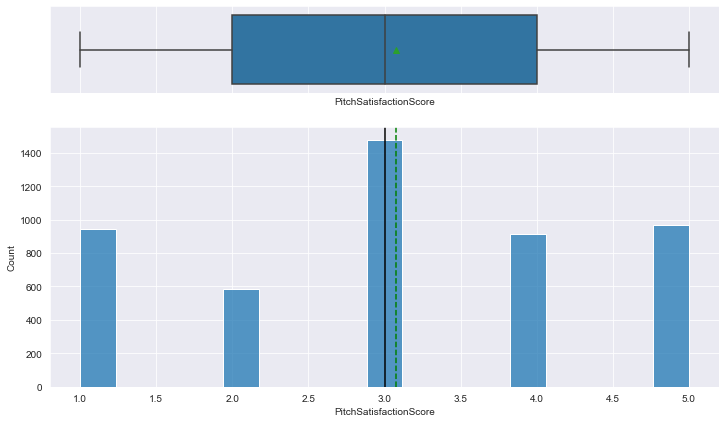

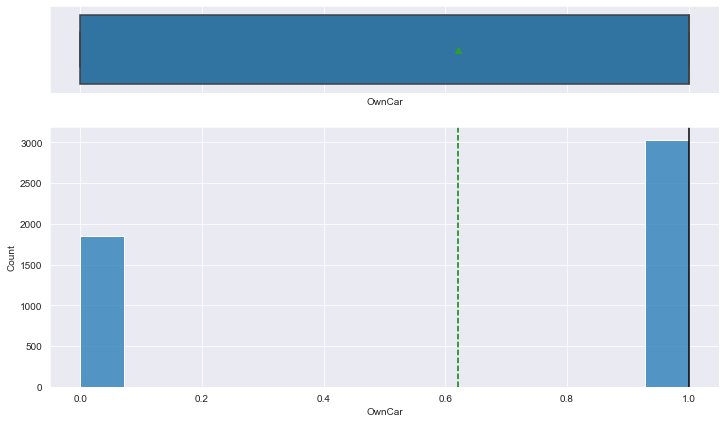

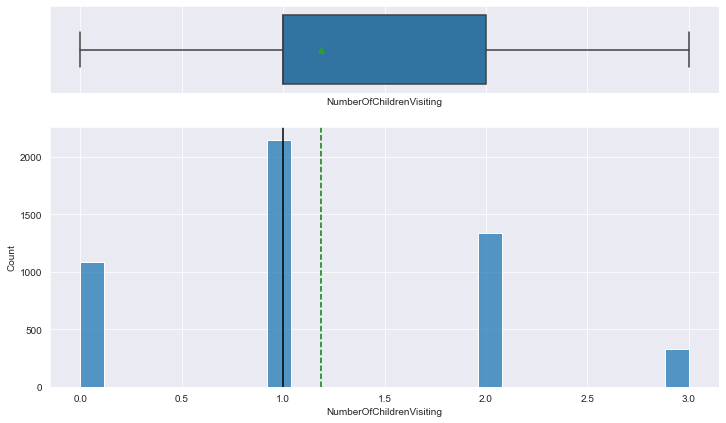

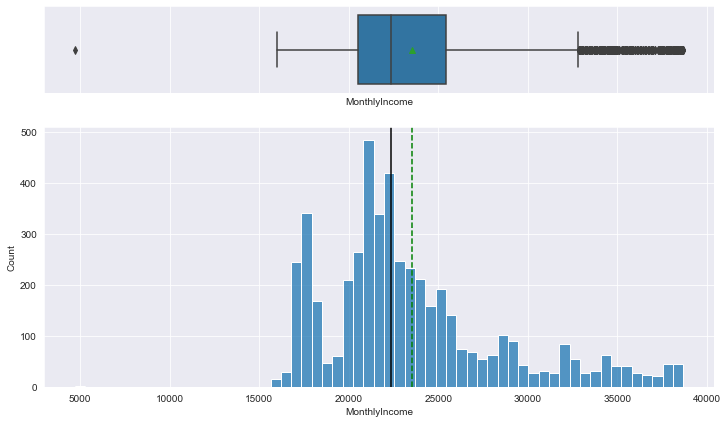

In [28]:
"""Re-examination of numerical features with boxplot and histograms"""
for i in range(len(num_cols)):
    hist_boxplot(df_clean, num_cols[i])

In [29]:
df_clean.describe(include=np.number)

CustomerID    ProdTaken          Age     CityTier  DurationOfPitch  \
count    4888.000000  4888.000000  4888.000000  4888.000000      4888.000000   
mean   202443.500000     0.188216    37.547259     1.654255        15.318944   
std      1411.188388     0.390925     9.104795     0.916583         8.006696   
min    200000.000000     0.000000    18.000000     1.000000         5.000000   
25%    201221.750000     0.000000    31.000000     1.000000         9.000000   
50%    202443.500000     0.000000    36.000000     1.000000        13.000000   
75%    203665.250000     0.000000    43.000000     3.000000        19.000000   
max    204887.000000     1.000000    61.000000     3.000000        36.000000   

       NumberOfPersonVisiting  NumberOfFollowups  PreferredPropertyStar  \
count             4888.000000        4888.000000            4888.000000   
mean                 2.905074           3.711129               3.577946   
std                  0.724891           0.998271               0.797005   
min                  1.000000           1.000000               3.000000   
25%                  2.000000           3.000000               3.000000   
50%                  3.000000           4.000000               3.000000   
75%                  3.000000           4.000000               4.000000   
max                  5.000000           6.000000               5.000000   

       NumberOfTrips     Passport  PitchSatisfactionScore       OwnCar  \
count    4888.000000  4888.000000             4888.000000  4888.000000   
mean        3.216244     0.290917                3.078151     0.620295   
std         1.754321     0.454232                1.365792     0.485363   
min         1.000000     0.000000                1.000000     0.000000   
25%         2.000000     0.000000                2.000000     0.000000   
50%         3.000000     0.000000                3.000000     1.000000   
75%         4.000000     1.000000                4.000000     1.000000   
max         8.000000     1.000000                5.000000     1.000000   

       NumberOfChildrenVisiting  MonthlyIncome  
count               4888.000000    4888.000000  
mean                   1.184738   23534.326412  
std                    0.852323    5034.190039  
min                    0.000000    4678.000000  
25%                    1.000000   20485.750000  
50%                    1.000000   22347.000000  
75%                    2.000000   25422.687500  
max                    3.000000   38677.000000

In [30]:
"""Closer examination of the categorical data for errors"""
cat_cols = df_clean.select_dtypes(exclude=np.number).columns.tolist()
for i in cat_cols:
    s = pd.Series(df_clean[i].unique(), name=i)
    print(i)
    print(s)
    print('*'*50)


TypeofContact
0       Self Enquiry
1    Company Invited
Name: TypeofContact, dtype: object
**************************************************
Occupation
0          Salaried
1       Free Lancer
2    Small Business
3    Large Business
Name: Occupation, dtype: object
**************************************************
Gender
0     Female
1       Male
2    Fe Male
Name: Gender, dtype: object
**************************************************
ProductPitched
0          Deluxe
1           Basic
2        Standard
3    Super Deluxe
4            King
Name: ProductPitched, dtype: object
**************************************************
MaritalStatus
0       Single
1     Divorced
2      Married
3    Unmarried
Name: MaritalStatus, dtype: object
**************************************************
Designation
0           Manager
1         Executive
2    Senior Manager
3               AVP
4                VP
Name: Designation, dtype: object
**************************************************


In [31]:
df_clean.describe(exclude=np.number)

TypeofContact Occupation Gender ProductPitched MaritalStatus  \
count           4888       4888   4888           4888          4888   
unique             2          4      3              5             4   
top     Self Enquiry   Salaried   Male          Basic       Married   
freq            3469       2368   2916           1842          2340   

       Designation  
count         4888  
unique           5  
top      Executive  
freq          1842

#### Notes
- All are fine with exception of **Gender** in which some entries have an error where *Female* is instead *Fe male*. *Those entries will simply need to be corrected.*

In [32]:
df_clean.Gender.replace({"Fe Male":"Female"}, inplace=True)
df_clean.Gender.unique()

array(['Female', 'Male'], dtype=object)

#### Adjust data types on dataset to be more appropriate

In [33]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4888 entries, 0 to 4887
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CustomerID                4888 non-null   int64  
 1   ProdTaken                 4888 non-null   int64  
 2   Age                       4888 non-null   float64
 3   TypeofContact             4888 non-null   object 
 4   CityTier                  4888 non-null   int64  
 5   DurationOfPitch           4888 non-null   float64
 6   Occupation                4888 non-null   object 
 7   Gender                    4888 non-null   object 
 8   NumberOfPersonVisiting    4888 non-null   int64  
 9   NumberOfFollowups         4888 non-null   float64
 10  ProductPitched            4888 non-null   object 
 11  PreferredPropertyStar     4888 non-null   float64
 12  MaritalStatus             4888 non-null   object 
 13  NumberOfTrips             4888 non-null   float64
 14  Passport

#### Notes
- Set **CustomerID** as the index for the dataset
- **Age, NumberOfFollowups, PreferredPropertyStar, NumberOfTrips,** and **NumberOfChildrenVisiting** would all be more appropriate as integers instead of floats as they track units which are generally treated as indivisible
- **TypeofContact, Occupation, Gender, ProductPitched, MaritalStatus** and **Designation** should all be a categorical data types.

In [34]:
df_clean.set_index('CustomerID', inplace=True)
integers = ['Age', 'NumberOfFollowups', 'PreferredPropertyStar', 'NumberOfTrips', 'NumberOfChildrenVisiting']
for i in integers:
    df_clean[i]= df_clean[i].astype('int64')
categories = ['TypeofContact', 'Occupation', 'Gender', 'ProductPitched', 'MaritalStatus', 'Designation']
for i in categories:
    df_clean[i] = df_clean[i].astype('category')


In [35]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4888 entries, 200000 to 204887
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   ProdTaken                 4888 non-null   int64   
 1   Age                       4888 non-null   int64   
 2   TypeofContact             4888 non-null   category
 3   CityTier                  4888 non-null   int64   
 4   DurationOfPitch           4888 non-null   float64 
 5   Occupation                4888 non-null   category
 6   Gender                    4888 non-null   category
 7   NumberOfPersonVisiting    4888 non-null   int64   
 8   NumberOfFollowups         4888 non-null   int64   
 9   ProductPitched            4888 non-null   category
 10  PreferredPropertyStar     4888 non-null   int64   
 11  MaritalStatus             4888 non-null   category
 12  NumberOfTrips             4888 non-null   int64   
 13  Passport                  4888 non-null  

In [36]:
df_clean.sample(7)

ProdTaken  Age    TypeofContact  CityTier  DurationOfPitch  \
CustomerID                                                               
202682              0   33     Self Enquiry         3             11.0   
201646              0   33     Self Enquiry         1              8.0   
204058              0   33  Company Invited         3             16.0   
201254              0   49     Self Enquiry         3             13.0   
203962              0   47  Company Invited         3             12.0   
201201              1   36     Self Enquiry         1             14.0   
200223              0   38     Self Enquiry         3              9.0   

                Occupation  Gender  NumberOfPersonVisiting  NumberOfFollowups  \
CustomerID                                                                      
202682            Salaried  Female                       3                  4   
201646            Salaried    Male                       2                  3   
204058      Small Business    Male                       3                  6   
201254      Small Business  Female                       3                  3   
203962      Small Business    Male                       4                  4   
201201      Small Business    Male                       3                  4   
200223            Salaried    Male                       3                  3   

           ProductPitched  PreferredPropertyStar MaritalStatus  NumberOfTrips  \
CustomerID                                                                      
202682              Basic                      4      Divorced              4   
201646              Basic                      3        Single              1   
204058             Deluxe                      3       Married              2   
201254             Deluxe                      3        Single              4   
203962             Deluxe                      3     Unmarried              6   
201201              Basic                      3        Single              2   
200223           Standard                      3       Married              1   

            Passport  PitchSatisfactionScore  OwnCar  \
CustomerID                                             
202682             0                       3       1   
201646             0                       3       1   
204058             0                       1       0   
201254             0                       4       0   
203962             1                       5       1   
201201             1                       4       1   
200223             0                       2       1   

            NumberOfChildrenVisiting     Designation  MonthlyIncome  
CustomerID                                                           
202682                             1       Executive        22609.0  
201646                             0       Executive        17500.0  
204058                             2         Manager        23346.0  
201254                             1         Manager        19507.0  
203962                             2         Manager        24450.0  
201201                             2       Executive        22347.0  
200223                             1  Senior Manager        25609.0

### Exploratory Data Analysis

In [37]:
"""New Dataframe with all cleaning for data exploration"""
df_eda = df_clean.copy()
del df_clean

In [38]:
# Table of general descriptive statistics for all features
df_eda.describe(include='all')

ProdTaken          Age TypeofContact     CityTier  DurationOfPitch  \
count   4888.000000  4888.000000          4888  4888.000000      4888.000000   
unique          NaN          NaN             2          NaN              NaN   
top             NaN          NaN  Self Enquiry          NaN              NaN   
freq            NaN          NaN          3469          NaN              NaN   
mean       0.188216    37.547259           NaN     1.654255        15.318944   
std        0.390925     9.104795           NaN     0.916583         8.006696   
min        0.000000    18.000000           NaN     1.000000         5.000000   
25%        0.000000    31.000000           NaN     1.000000         9.000000   
50%        0.000000    36.000000           NaN     1.000000        13.000000   
75%        0.000000    43.000000           NaN     3.000000        19.000000   
max        1.000000    61.000000           NaN     3.000000        36.000000   

       Occupation Gender  NumberOfPersonVisiting  NumberOfFollowups  \
count        4888   4888             4888.000000        4888.000000   
unique          4      2                     NaN                NaN   
top      Salaried   Male                     NaN                NaN   
freq         2368   2916                     NaN                NaN   
mean          NaN    NaN                2.905074           3.711129   
std           NaN    NaN                0.724891           0.998271   
min           NaN    NaN                1.000000           1.000000   
25%           NaN    NaN                2.000000           3.000000   
50%           NaN    NaN                3.000000           4.000000   
75%           NaN    NaN                3.000000           4.000000   
max           NaN    NaN                5.000000           6.000000   

       ProductPitched  PreferredPropertyStar MaritalStatus  NumberOfTrips  \
count            4888            4888.000000          4888    4888.000000   
unique              5                    NaN             4            NaN   
top             Basic                    NaN       Married            NaN   
freq             1842                    NaN          2340            NaN   
mean              NaN               3.577946           NaN       3.216244   
std               NaN               0.797005           NaN       1.754321   
min               NaN               3.000000           NaN       1.000000   
25%               NaN               3.000000           NaN       2.000000   
50%               NaN               3.000000           NaN       3.000000   
75%               NaN               4.000000           NaN       4.000000   
max               NaN               5.000000           NaN       8.000000   

           Passport  PitchSatisfactionScore       OwnCar  \
count   4888.000000             4888.000000  4888.000000   
unique          NaN                     NaN          NaN   
top             NaN                     NaN          NaN   
freq            NaN                     NaN          NaN   
mean       0.290917                3.078151     0.620295   
std        0.454232                1.365792     0.485363   
min        0.000000                1.000000     0.000000   
25%        0.000000                2.000000     0.000000   
50%        0.000000                3.000000     1.000000   
75%        1.000000                4.000000     1.000000   
max        1.000000                5.000000     1.000000   

        NumberOfChildrenVisiting Designation  MonthlyIncome  
count                4888.000000        4888    4888.000000  
unique                       NaN           5            NaN  
top                          NaN   Executive            NaN  
freq                         NaN        1842            NaN  
mean                    1.184738         NaN   23534.326412  
std                     0.852323         NaN    5034.190039  
min                     0.000000         NaN    4678.000000  
25%                     1.000000         NaN   20485.7

In [39]:
df_eda[df_eda['ProdTaken'] == 1].describe(include='all')

ProdTaken         Age TypeofContact    CityTier  DurationOfPitch  \
count       920.0  920.000000           920  920.000000       920.000000   
unique        NaN         NaN             2         NaN              NaN   
top           NaN         NaN  Self Enquiry         NaN              NaN   
freq          NaN         NaN           610         NaN              NaN   
mean          1.0   34.829348           NaN    1.819565        16.683696   
std           0.0    9.828021           NaN    0.958354         8.305049   
min           1.0   18.000000           NaN    1.000000         6.000000   
25%           1.0   28.000000           NaN    1.000000        10.000000   
50%           1.0   33.000000           NaN    1.000000        15.000000   
75%           1.0   41.000000           NaN    3.000000        23.000000   
max           1.0   60.000000           NaN    3.000000        36.000000   

       Occupation Gender  NumberOfPersonVisiting  NumberOfFollowups  \
count         920    920              920.000000         920.000000   
unique          4      2                     NaN                NaN   
top      Salaried   Male                     NaN                NaN   
freq          414    578                     NaN                NaN   
mean          NaN    NaN                2.919565           3.942391   
std           NaN    NaN                0.702899           1.002688   
min           NaN    NaN                2.000000           1.000000   
25%           NaN    NaN                2.000000           3.000000   
50%           NaN    NaN                3.000000           4.000000   
75%           NaN    NaN                3.000000           5.000000   
max           NaN    NaN                4.000000           6.000000   

       ProductPitched  PreferredPropertyStar MaritalStatus  NumberOfTrips  \
count             920             920.000000           920     920.000000   
unique              5                    NaN             4            NaN   
top             Basic                    NaN       Married            NaN   
freq              552                    NaN           326            NaN   
mean              NaN               3.741304           NaN       3.270652   
std               NaN               0.857934           NaN       1.890244   
min               NaN               3.000000           NaN       1.000000   
25%               NaN               3.000000           NaN       2.000000   
50%               NaN               3.000000           NaN       3.000000   
75%               NaN               5.000000           NaN       4.000000   
max               NaN               5.000000           NaN       8.000000   

          Passport  PitchSatisfactionScore      OwnCar  \
count   920.000000              920.000000  920.000000   
unique         NaN                     NaN         NaN   
top            NaN                     NaN         NaN   
freq           NaN                     NaN         NaN   
mean      0.536957                3.223913    0.608696   
std       0.498904                1.327648    0.488308   
min       0.000000                1.000000    0.000000   
25%       0.000000                2.000000    0.000000   
50%       1.000000                3.000000    1.000000   
75%       1.000000                4.000000    1.000000   
max       1.000000                5.000000    1.000000   

        NumberOfChildrenVisiting Designation  MonthlyIncome  
count                 920.000000         920     920.000000  
unique                       NaN           5            NaN  
top                          NaN   Executive            NaN  
freq                         NaN         552            NaN  
mean                    1.198913         NaN   22178.885870  
std                     0.861837         NaN    4567.349943  
min                     0.000000         NaN   16009.000000  
25%                     1.000000         NaN   18475.250000  
50%                     1.000000         NaN   21274.000000  


In [40]:
df_eda[df_eda['ProdTaken'] == 0].describe(include="all")

ProdTaken          Age TypeofContact     CityTier  DurationOfPitch  \
count      3968.0  3968.000000          3968  3968.000000      3968.000000   
unique        NaN          NaN             2          NaN              NaN   
top           NaN          NaN  Self Enquiry          NaN              NaN   
freq          NaN          NaN          2859          NaN              NaN   
mean          0.0    38.177419           NaN     1.615927        15.002520   
std           0.0     8.811116           NaN     0.902434         7.903406   
min           0.0    18.000000           NaN     1.000000         5.000000   
25%           0.0    32.000000           NaN     1.000000         9.000000   
50%           0.0    36.000000           NaN     1.000000        13.000000   
75%           0.0    44.000000           NaN     3.000000        18.000000   
max           0.0    61.000000           NaN     3.000000        36.000000   

       Occupation Gender  NumberOfPersonVisiting  NumberOfFollowups  \
count        3968   3968             3968.000000        3968.000000   
unique          3      2                     NaN                NaN   
top      Salaried   Male                     NaN                NaN   
freq         1954   2338                     NaN                NaN   
mean          NaN    NaN                2.901714           3.657510   
std           NaN    NaN                0.729940           0.989682   
min           NaN    NaN                1.000000           1.000000   
25%           NaN    NaN                2.000000           3.000000   
50%           NaN    NaN                3.000000           4.000000   
75%           NaN    NaN                3.000000           4.000000   
max           NaN    NaN                5.000000           6.000000   

       ProductPitched  PreferredPropertyStar MaritalStatus  NumberOfTrips  \
count            3968            3968.000000          3968    3968.000000   
unique              5                    NaN             4            NaN   
top            Deluxe                    NaN       Married            NaN   
freq             1528                    NaN          2014            NaN   
mean              NaN               3.540071           NaN       3.203629   
std               NaN               0.777427           NaN       1.721282   
min               NaN               3.000000           NaN       1.000000   
25%               NaN               3.000000           NaN       2.000000   
50%               NaN               3.000000           NaN       3.000000   
75%               NaN               4.000000           NaN       4.000000   
max               NaN               5.000000           NaN       8.000000   

           Passport  PitchSatisfactionScore       OwnCar  \
count   3968.000000             3968.000000  3968.000000   
unique          NaN                     NaN          NaN   
top             NaN                     NaN          NaN   
freq            NaN                     NaN          NaN   
mean       0.233871                3.044355     0.622984   
std        0.423344                1.372439     0.484700   
min        0.000000                1.000000     0.000000   
25%        0.000000                2.000000     0.000000   
50%        0.000000                3.000000     1.000000   
75%        0.000000                4.000000     1.000000   
max        1.000000                5.000000     1.000000   

        NumberOfChildrenVisiting Designation  MonthlyIncome  
count                3968.000000        3968    3968.000000  
unique                       NaN           5            NaN  
top                          NaN     Manager            NaN  
freq                         NaN        1528            NaN  
mean                    1.181452         NaN   23848.591860  
std                     0.850178         NaN    5085.566743  
min                     0.000000         NaN    4678.000000  
25%                     1.000000         NaN   20761.750000  
50%           

In [41]:
df_eda.columns

Index(['ProdTaken', 'Age', 'TypeofContact', 'CityTier', 'DurationOfPitch',
       'Occupation', 'Gender', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'MaritalStatus',
       'NumberOfTrips', 'Passport', 'PitchSatisfactionScore', 'OwnCar',
       'NumberOfChildrenVisiting', 'Designation', 'MonthlyIncome'],
      dtype='object')

### Aspects to explore and assess within the data:
- What features may be related to customer purchasing a plan?
- What features may be associated with accepting each type of plan?
- What are the different potential customer profiles of these customers?

#### Features can be grouped into three types of features:
- **Descriptive features of the customer**: Age, Gender, Occupation, NumberOfPersonVisiting, PreferredPropertyStar, MaritalStatus, NumberOfTrips, Passport, OwnCar, NumberOfChildrenVisiting, Designation, MonthlyIncome
- **Descriptive features of the sale**: TypeofContact, CityTier, DurationOfPitch, , ProductPitched, NumberOfFollowups, PitchSatisfactionScore
- **Result or target feature**: ProdTaken

*All of these features are potentially relevant, but thinking about them along these lines will assist in exploring the data for potential trends. In part because it will limit the figures viewed at any one time*


#### Assess the target variable

In [42]:
def barplot_annot(dataframe, feature, annot='percent', 
                   n=None, h=0, w=0, s = 12):
    """
    Barplot with percentage annotation of counts on top.
    
    dataframe: dataframe containing relevant data 
    feature: columns in dataframe to be plotted
    annot: whether to annotate plots with percent, count, or both
    n: displays the top n catgory levels (default is None, i.e., display all levels)
    h: vertical position of annotation above bar
    w: lateral position of annotation above bar
    s: fontsize for annotations
    
    """
    rows = len(dataframe[feature])
    count = dataframe[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize(n + 1, 5))
        
    ax = sns.countplot(data=dataframe, x=feature, 
                       order=dataframe[feature].value_counts().index[:n].sort_values())
    for p in ax.patches:
        if annot == 'percent':
            label = "{:.1f}%".format(100 * p.get_height()/rows)
        elif annot == 'count':
            label = p.get_height()
        else:
            perc = "{:.1f}%".format(100 * p.get_height()/rows)
            num = p.get_height()
            label = "{} ({})".format(num, perc)

        x = p.get_x() + p.get_width() / 2 - p.get_width() * w
        y = p.get_y() + p.get_height() + p.get_height() * h
        
        ax.annotate(label, (x, y), size = s)
    
    plt.tight_layout()
    plt.title(feature, fontsize=25)
    sns.despine()
    plt.show()

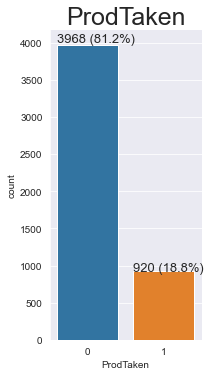

<Figure size 432x288 with 0 Axes>

In [43]:
"""How often do customer actually purchase a product?"""
barplot_annot(df_eda, 'ProdTaken',h=0.01, w=0.5, s=13, annot='perc')
plt.savefig("Product Purchased")

**Customers only take a product 18.8% of the time.** Out of 4888 customers only 920 purchased a travel package.

In [3]:
plt.figure(figsize=(6, 6))
ax = sns.countplot(data=df_eda, x='ProdTaken')
plt.title("Customers who Purchased Travel Plans", fontsize=16)
plt.xlabel("Product Purchased", fontsize=14)
plt.ylabel("Number of Customers", fontsize=14)
plt.xticks(ticks=[0, 1], labels=["Yes", "No"])
plt.tight_layout()
sns.despine()
plt.savefig("PurchasedPlan", dpi=300)



NameError: name 'plt' is not defined

In [45]:
# Create column lists of features of customer and features of sale for easier comparisons
# Include the target in both!
customers = [
            "Age",
            "Gender",
            "Occupation",
            "NumberOfPersonVisiting",
            "PreferredPropertyStar",
            "MaritalStatus",
            "NumberOfTrips",
            "Passport",
            "OwnCar",
            "NumberOfChildrenVisiting",
            "Designation",
            "MonthlyIncome",
            "ProdTaken"
            ]

sales = [
        "TypeofContact",
        "CityTier",
        "DurationOfPitch",
        "ProductPitched",
        "NumberOfFollowups",
        "PitchSatisfactionScore",
        "ProdTaken"
        ]

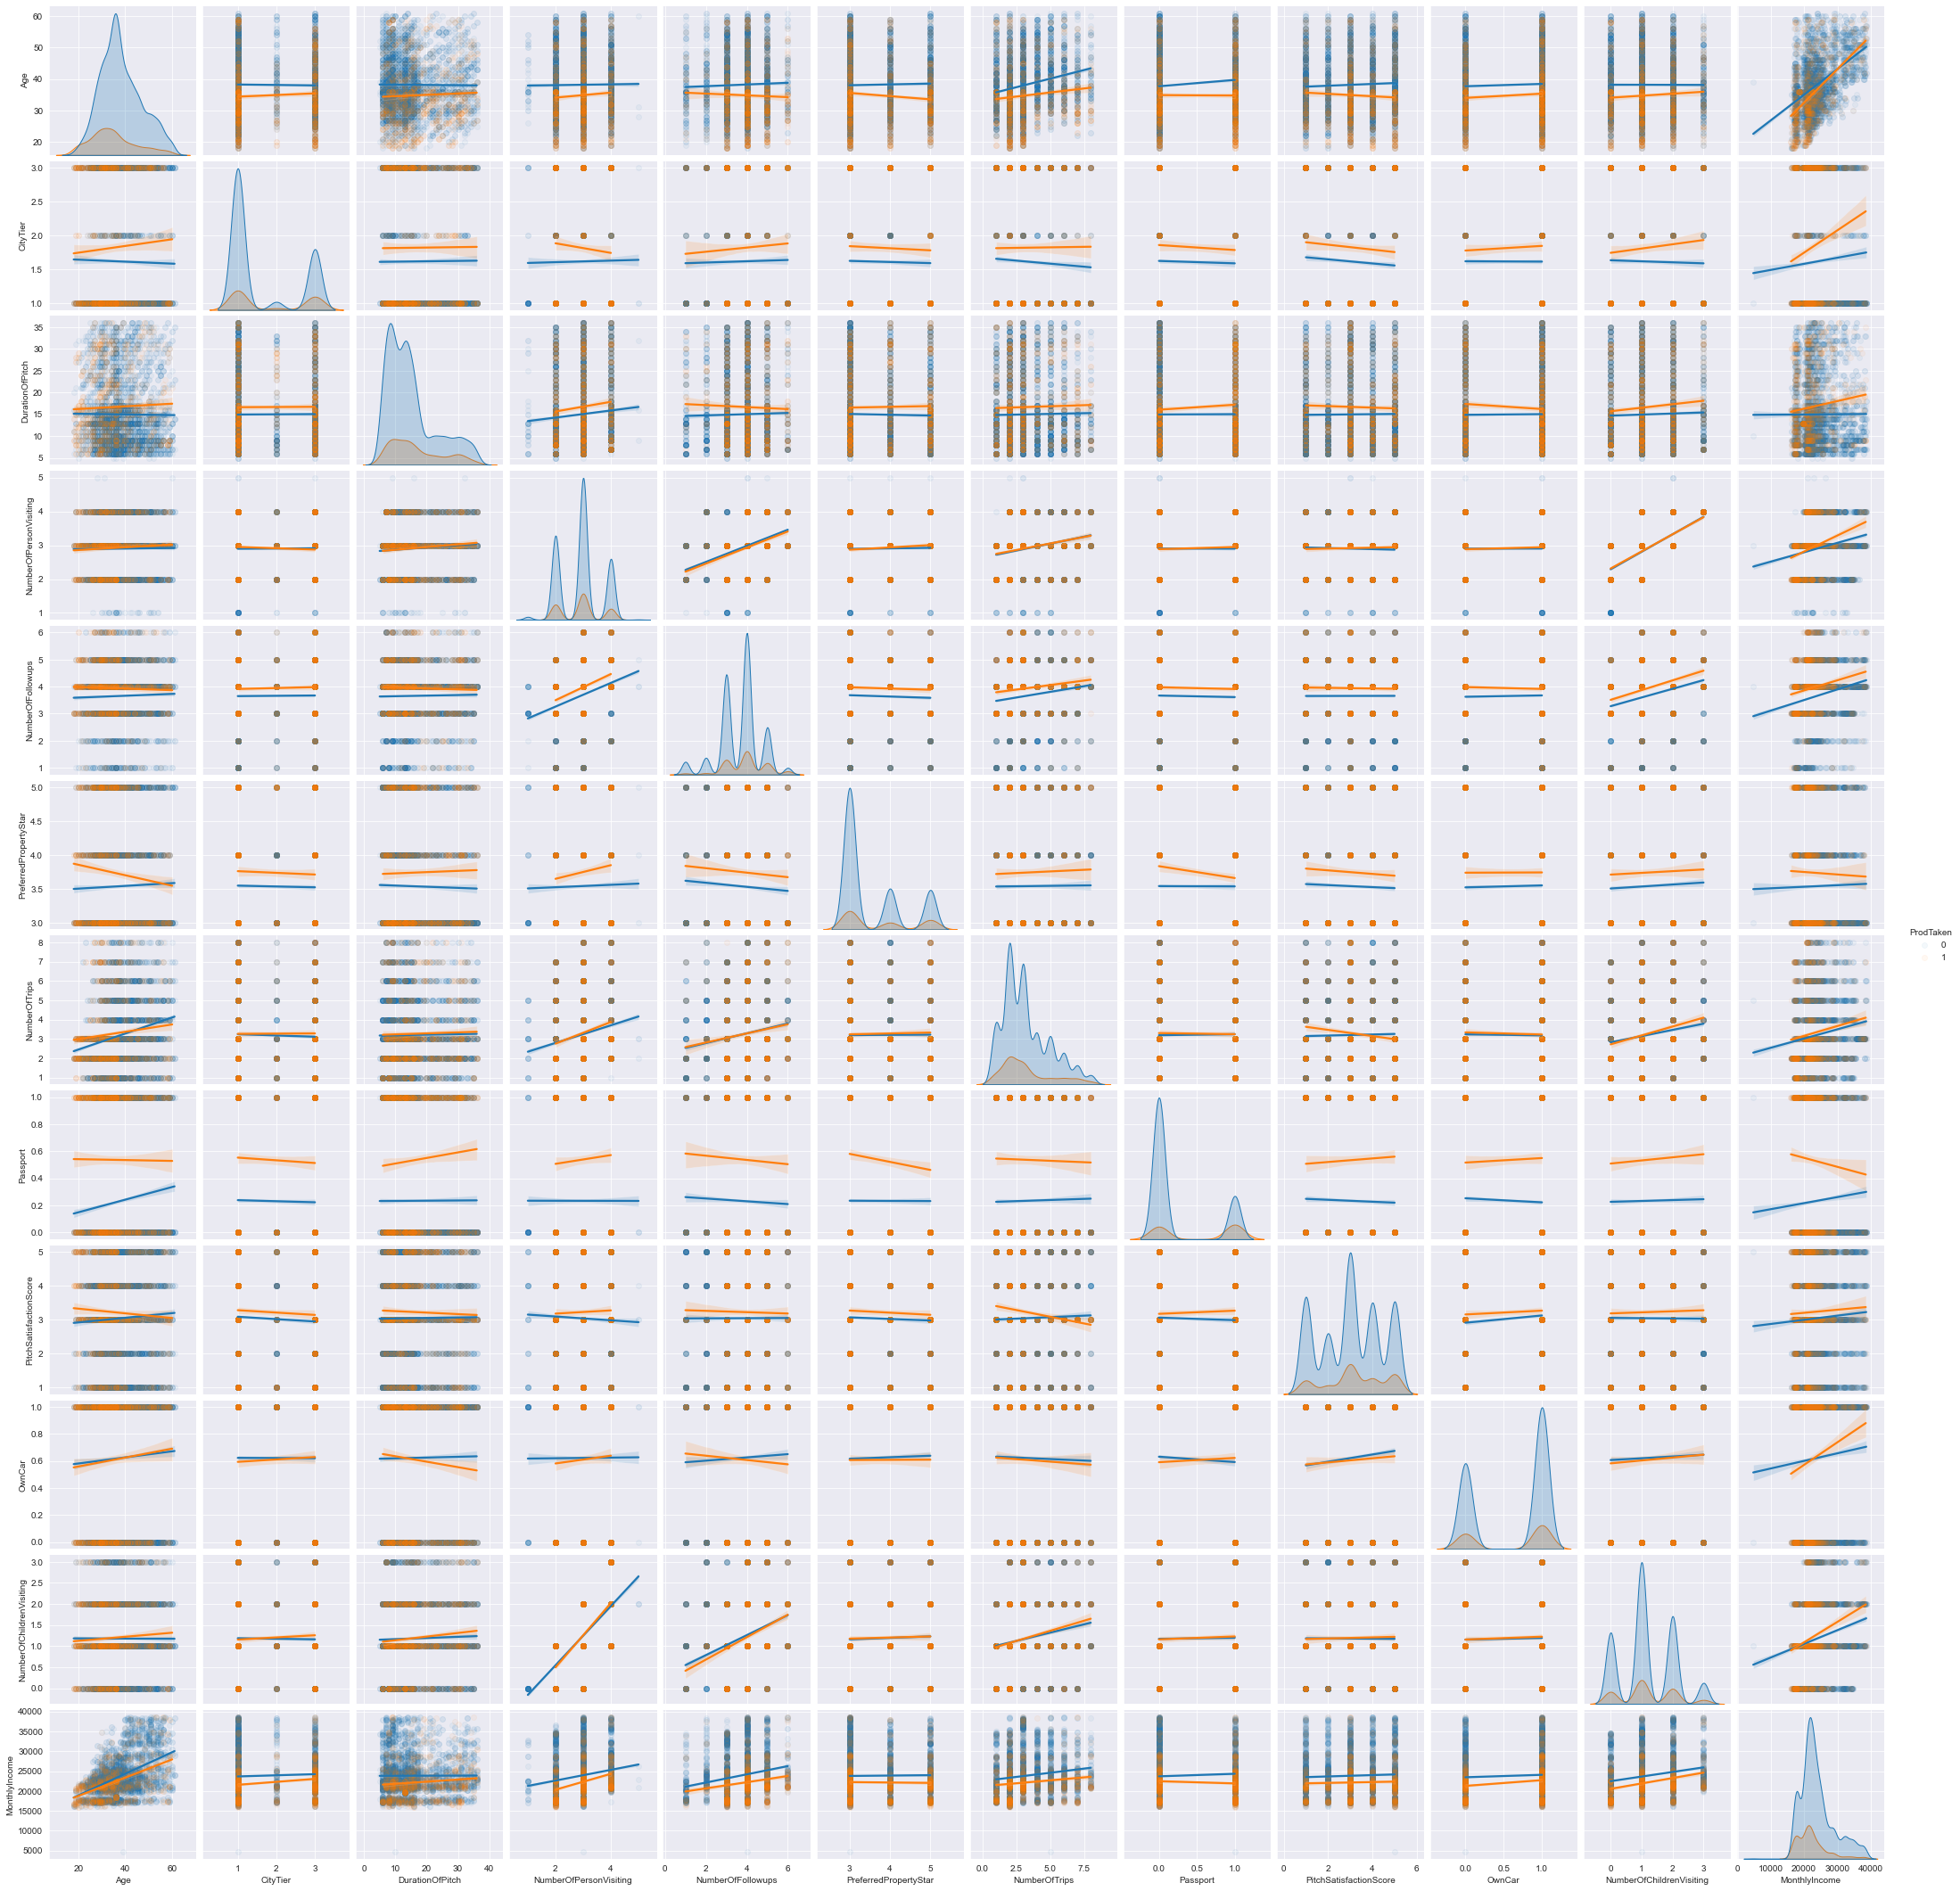

In [46]:
sns.pairplot(df_eda, hue='ProdTaken', kind='reg', plot_kws={'scatter_kws':{'alpha':0.05}})

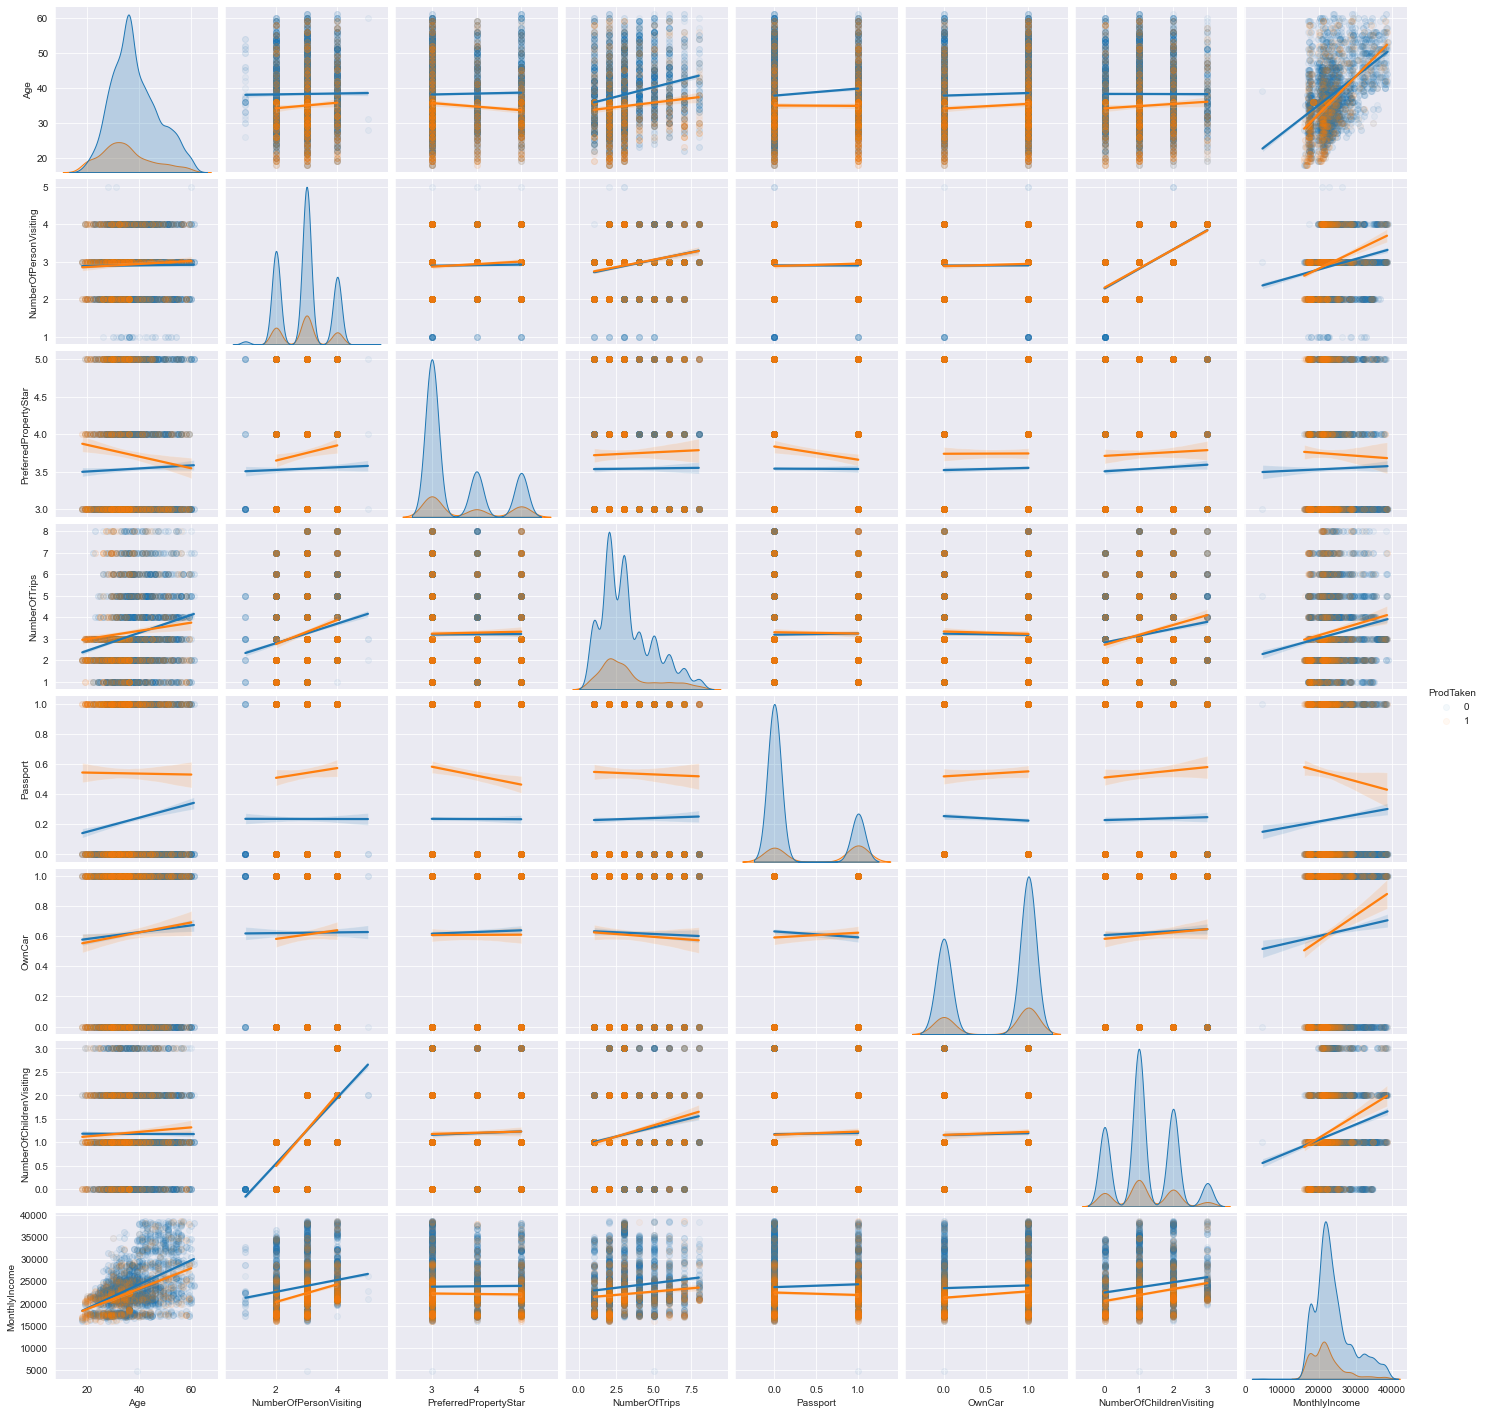

In [47]:
"""How might features of the customer be related to them purchasing a product?"""
sns.pairplot(df_eda[customers], hue='ProdTaken', kind='reg', plot_kws={'scatter_kws':{'alpha':0.05}})

#### Notes
No dramatic clustering in any of the trends with regards to customers who took or did not purchase a product based on numerical features. Interestingly, you can see on the univariate distributions, ththe customers who took the package tend to be essentially the same, just at a lower frequency, which makes sense as most customers do not take a package. There are some potential differences to explore dmonstrated by the trend lines in these plots:
- With the exception of Monthly Income, younger individuals may be more likely to purchase a travel plan (the trendlines for purchased are consistently lower across the features.
- Customers who purchased a plan also tend to prefer higher higher property stars.
- An indivual with a passport is more likely to purchase a travel plan
- One of the few opposite potential trends for customers who purchased a plan versus those who did not is on Passport and Monthly Income. Customers who bought a plan are more likely to have a Passport if they have a lower income, but as they get wealthier they become less likely to have a passport. Those who did not purchase a plan are the inverse.

You can observe other trends, unrelated to whether a customer purchased or not. Unsurprisingly, Number of children visiting and number of people visiting appear to have a positive correlation, as children are still people, so will be counted in both. There also is a positive trend for Age and Monthly Income, but the relationship is not actually linear. Just it's lower bound on Age. Essentially, if you are older, the minimum income likely to be higher, but there appears to be no upper bound on monthly income related to age.


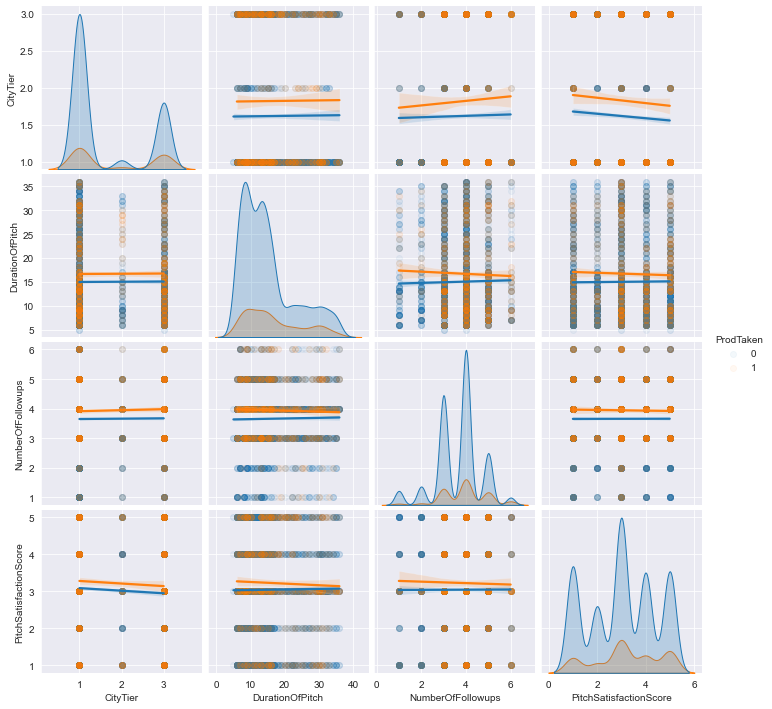

In [48]:
"""How might feature of the sale be related to a customer purchasing a product?"""
sns.pairplot(df_eda[sales], hue='ProdTaken', kind='reg', plot_kws={'scatter_kws':{'alpha':0.05}})

#### Notes
We observe the same effect with regards to sales features as we saw with customers. There are no obvious shifts in the likelihood of a customer purchasing a travel package based on a single numerical feature of the sale overall. There is an interesting overall trend though when looking at the position of trendlines of customers who purchased a plan versus those who did not. *Slight increases in all sales metrics may lead to a slight increase in sales themselves.* However, the difference does appear to be slight, but it is consistent that the trend line for customers who bought plans is shifted above those who did not slightly on all metrics.

<AxesSubplot:>

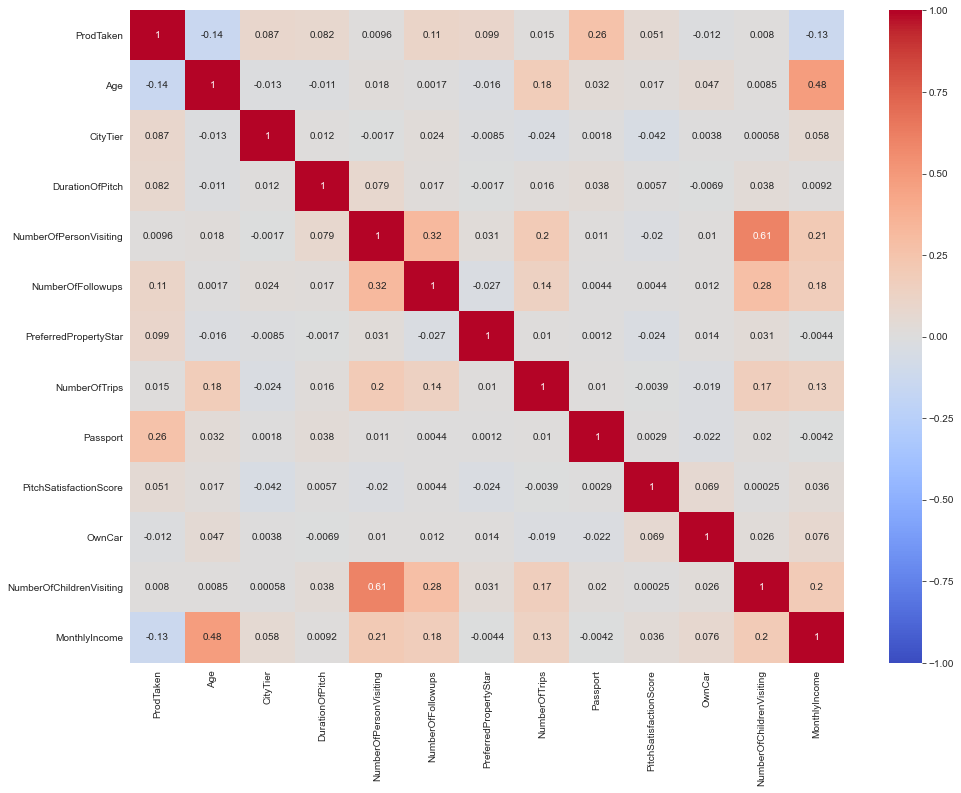

In [49]:
plt.figure(figsize=(16, 12))
sns.heatmap(df_eda.corr(), vmin=-1, vmax=1, cmap="coolwarm", annot=True)

#### Notes
- There are no incredibly strong correlations, which is good for the modeling as it suggests independence of most of the features
- The two strongest are between **Number of Person Visiting and Number of Children visitin (+0.61)** and **Age and Monthly Income (+0.48).** The first and strongest is likely to be a double count of children, which will likely cause collinearity so one will need to be removed. Age and Monthly Income has a relationship, but it's not perfect so may or may not cause colinearity issues.

ProdTaken          0    1   All
Occupation                     
All             3968  920  4888
Salaried        1954  414  2368
Small Business  1700  384  2084
Large Business   314  120   434
Free Lancer        0    2     2
************************************************************************************************************************


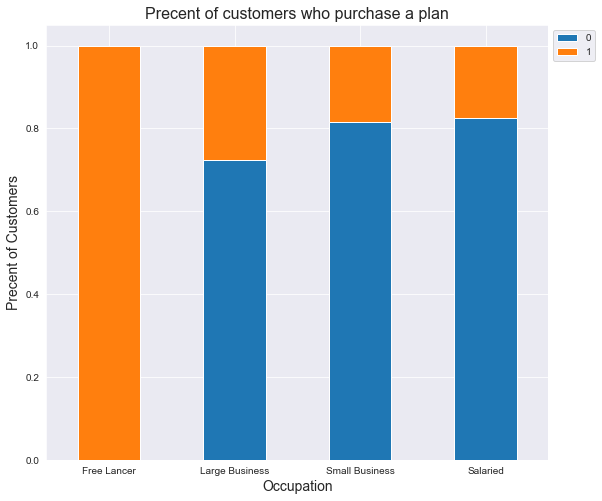

In [50]:
count = df_eda["Occupation"].nunique()
sorter = df_eda["ProdTaken"].value_counts().index[-1]
tab1 = pd.crosstab(df_eda["Occupation"], df_eda["ProdTaken"], margins=True).sort_values(by=sorter, ascending=False)
print(tab1)
print("*"*120)
tab = pd.crosstab(df_eda["Occupation"], df_eda["ProdTaken"], normalize="index").sort_values(by=sorter, ascending=False)

tab.plot(kind="bar", stacked=True, figsize=(count + 5, 8))
plt.title("Precent of customers who purchase a plan", fontsize=16)
plt.xlabel("Occupation", fontsize=14)
plt.ylabel("Precent of Customers", fontsize=14)
plt.xticks(rotation=0)
plt.legend(loc="lower left", frameon=False)
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
# plt.show()
plt.savefig("PercentCustomersPurchasePlanByOccupatoin", dpi=300)

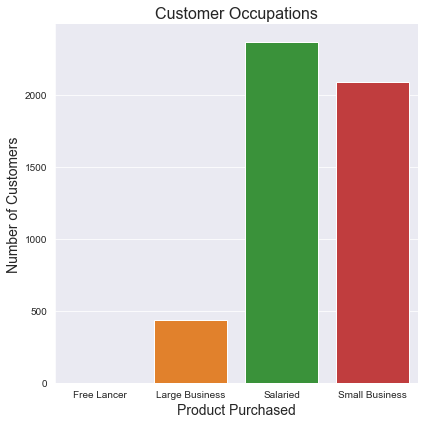

In [51]:
plt.figure(figsize=(6, 6))
sns.countplot(data=df_eda, x="Occupation")
plt.title("Customer Occupations", fontsize=16)
plt.xlabel("Product Purchased", fontsize=14)
plt.ylabel("Number of Customers", fontsize=14)
plt.tight_layout()
sns.despine()
plt.savefig("OccupationCounts", dpi=300)

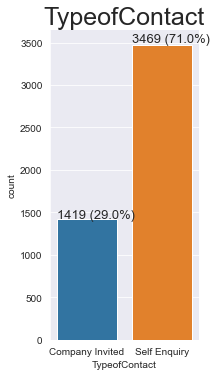

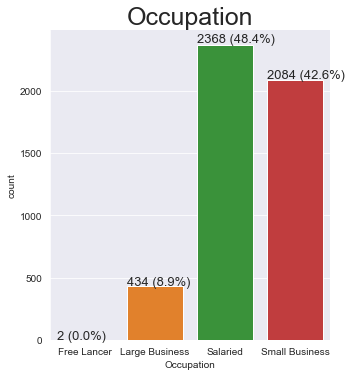

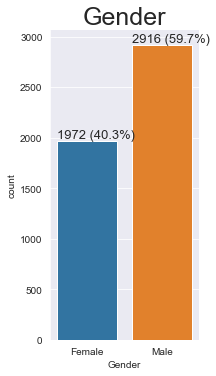

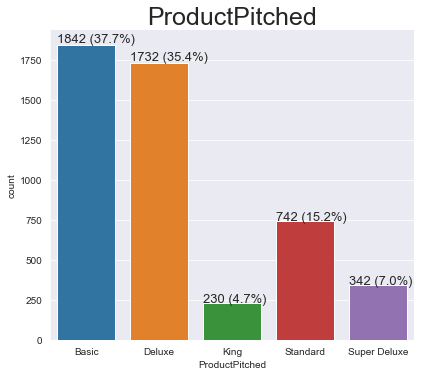

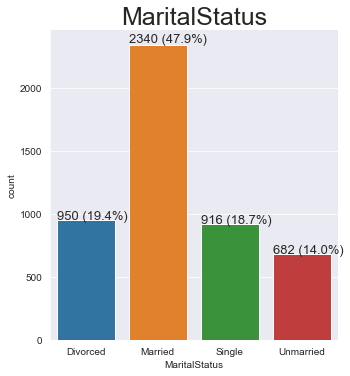

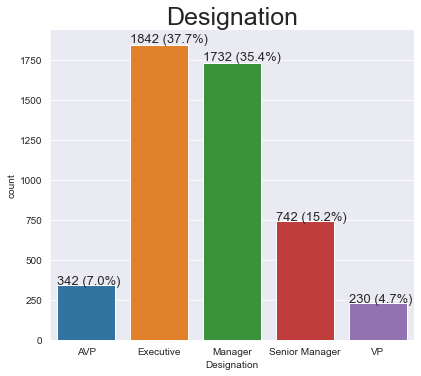

In [52]:
"""Examination of distributions of categorical data"""
for i in range(len(cat_cols)):
    barplot_annot(df_eda, cat_cols[i], h=0.01, w=0.5, s=13, annot='both')


#### Notes
- The **majority of contacts made are self enquiries by the customer (71%)**. Only 1419 of 4888 customers were contacted initially by a sales representative.
- The **majority of potential customers are Salaried or Small Business Owner**. Large Business owners are small share of the potential customers that have been interacted with (8.9%) and there are 2 Free Lancer customers out of the 4888.
- **Male customers are more common (59.7%) than female.**
- The most common package pitched is the Basic (37.7%), followed closely by the Deluxe (35.4%). **Together Basic and Deluxe make up over 70% of the plans pitched by sales.**
- Nearly half of potential customers are Married (47.9%). Unmarried makes up another 14%, therefore **couples more broadly make up over 60% of the potential customer base** while the remaining are split nearly evenly between Divorced or Single.
- **Over 70% of potential customers hold the designation of either Executive or Manager.** Vice President, Assistant Vice President, and Senior Manager make up the remaining.


In [53]:
def stacked_barplot(df, predictor, target):
    """
    Print the category counts and plot a stacked bar plot.
    
    df: dataframe
    predictor: independent variable
    target: target (dependent) variable
    """
    count = df[predictor].nunique()
    sorter = df[target].value_counts().index[-1]
    tab1 = pd.crosstab(df[predictor], df[target], margins=True).sort_values(by=sorter, ascending=False)
    print(tab1)
    print("*"*120)
    tab = pd.crosstab(df[predictor], df[target], normalize="index").sort_values(by=sorter, ascending=False)
    
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 5))
    plt.legend(loc="lower left", frameon=False)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1))
    plt.show()

ProdTaken           0    1   All
TypeofContact                   
All              3968  920  4888
Self Enquiry     2859  610  3469
Company Invited  1109  310  1419
************************************************************************************************************************


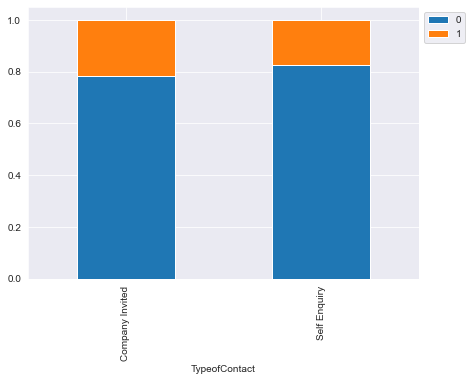

ProdTaken          0    1   All
Occupation                     
All             3968  920  4888
Salaried        1954  414  2368
Small Business  1700  384  2084
Large Business   314  120   434
Free Lancer        0    2     2
************************************************************************************************************************


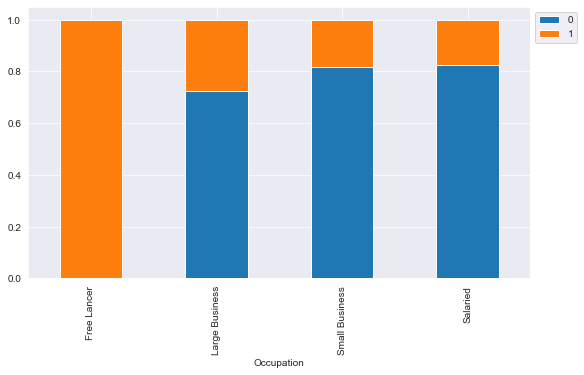

ProdTaken     0    1   All
Gender                    
All        3968  920  4888
Male       2338  578  2916
Female     1630  342  1972
************************************************************************************************************************


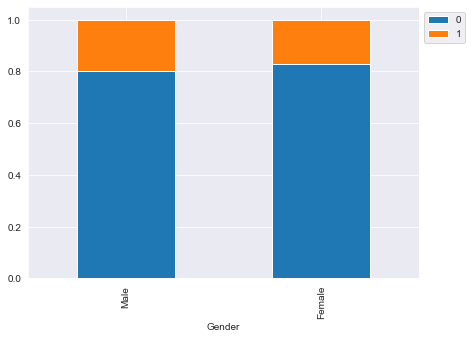

ProdTaken          0    1   All
ProductPitched                 
All             3968  920  4888
Basic           1290  552  1842
Deluxe          1528  204  1732
Standard         618  124   742
King             210   20   230
Super Deluxe     322   20   342
************************************************************************************************************************


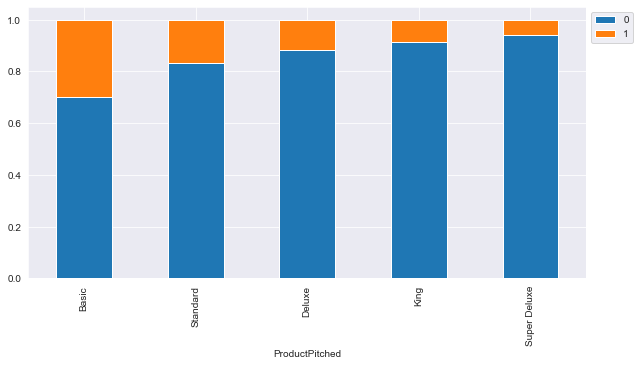

ProdTaken         0    1   All
MaritalStatus                 
All            3968  920  4888
Married        2014  326  2340
Single          612  304   916
Unmarried       516  166   682
Divorced        826  124   950
************************************************************************************************************************


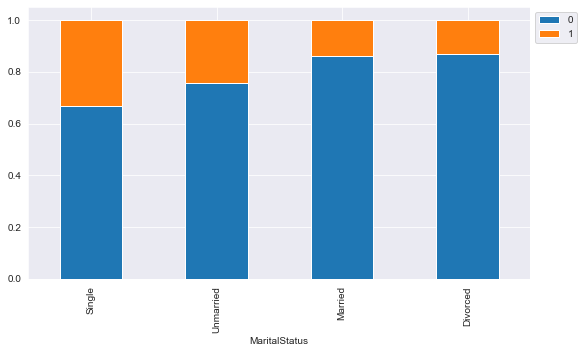

ProdTaken          0    1   All
Designation                    
All             3968  920  4888
Executive       1290  552  1842
Manager         1528  204  1732
Senior Manager   618  124   742
AVP              322   20   342
VP               210   20   230
************************************************************************************************************************


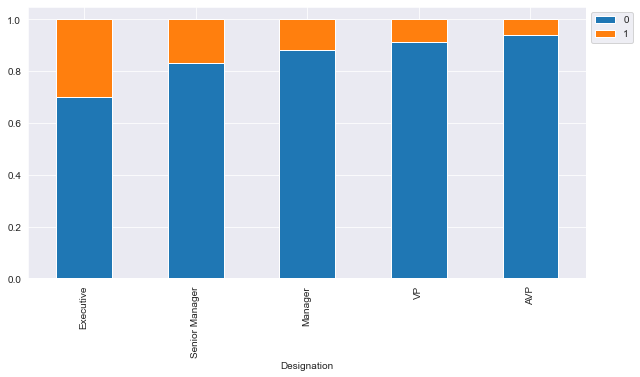

In [54]:
for i in range(len(cat_cols)):
    stacked_barplot(df_eda, cat_cols[i], 'ProdTaken')

#### Notes
- There is little difference in the purchasing rate of potential customer depending on whether the customer has enquired themself or been invited by the company.
- Proportionally, all Free Lancers purchased plans - however there are only 2 in the dataset, so this is not reliable. Regardless they may be an occupation bracket the company should pursue. **Customers who work in Large Businesses have the second highest proportion of acceptance. Due to the fact that this group has a higher rate of purchasing, but has a low percentage of of the potential customers (8.9%) this is an occupation the company could likely focus on to broaden its customer base more effectively.** Small Business and Salaried customers, which make up the bulk of the current customer base have approximately a 20% purchase rate, while Large Businesses currently have approximately a 30%.
- There is no major difference on acceptance rate by Gender. This does mean, based on the make-up of the customer base being slightly lower in Female, that Females may be an area the company could easily expand into.
- On packages, **Basic has the highest purchase rate ar approxiamtely 30%.** This is followed by Standard at around 20%, and then it gets progressively lower as you move to Deluxe, King, and Super Deluxe.
- **Executives are not only the largest customer base for designation, but also have the highest purchase rate.** This is followed by Senior Managers though, which make up only 15% of the customer base, therefore, this may be a group for the company to pursue further.


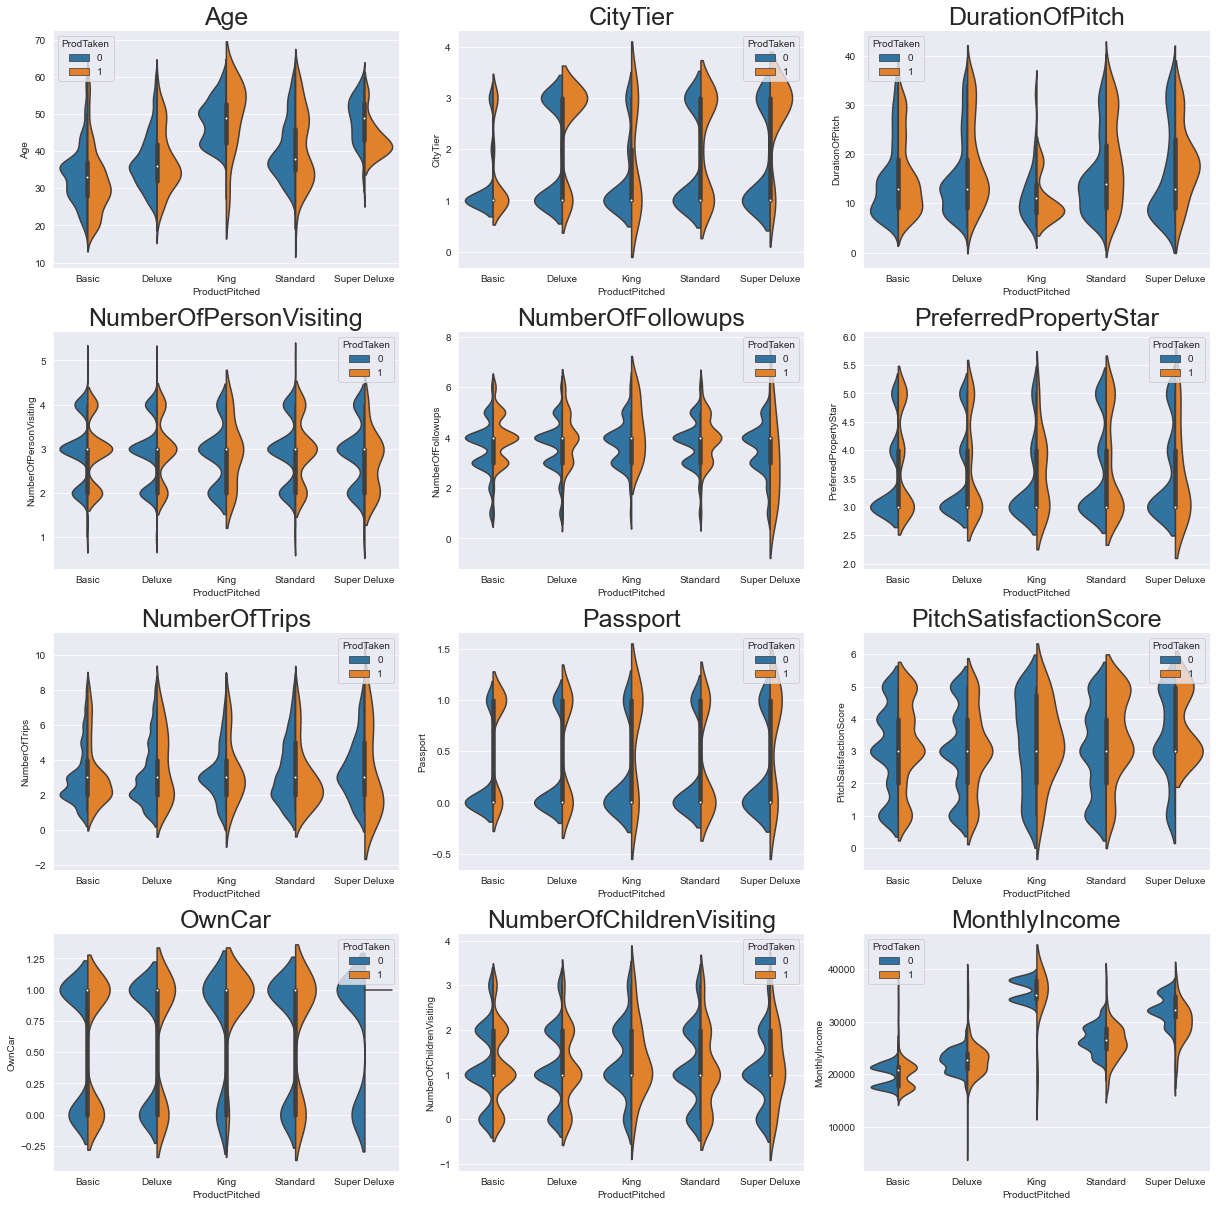

In [164]:
"""Does the product pitched influence a customers purchase?"""
plt.figure(figsize=(17, 75))
for i in range(len(num_cols)):
    plt.subplot(18, 3, i + 1)
    sns.violinplot(data=df_eda, x='ProductPitched', y=num_cols[i], hue="ProdTaken", split=True)
    plt.tight_layout()
    plt.title(num_cols[i], fontsize=25)
    sns.despine()

#### Notes
- Most distribution are similar, but there are some differences.
- Of customers who were pitched the King Travel plan, older customers from that group generally purchased the plan.
- Customers who purchased the Super Deluxe tend to be between mid 30s to 50, while older than that may have been pitched the plan, but frequently did not purchase.
- With the exception of the King Travel plan, customers who experienced longer pitches had a tendency to purchase a travel plan.
- Customers are less likely to purchase the Super Deluxe package if they are bringing more than 3 people.

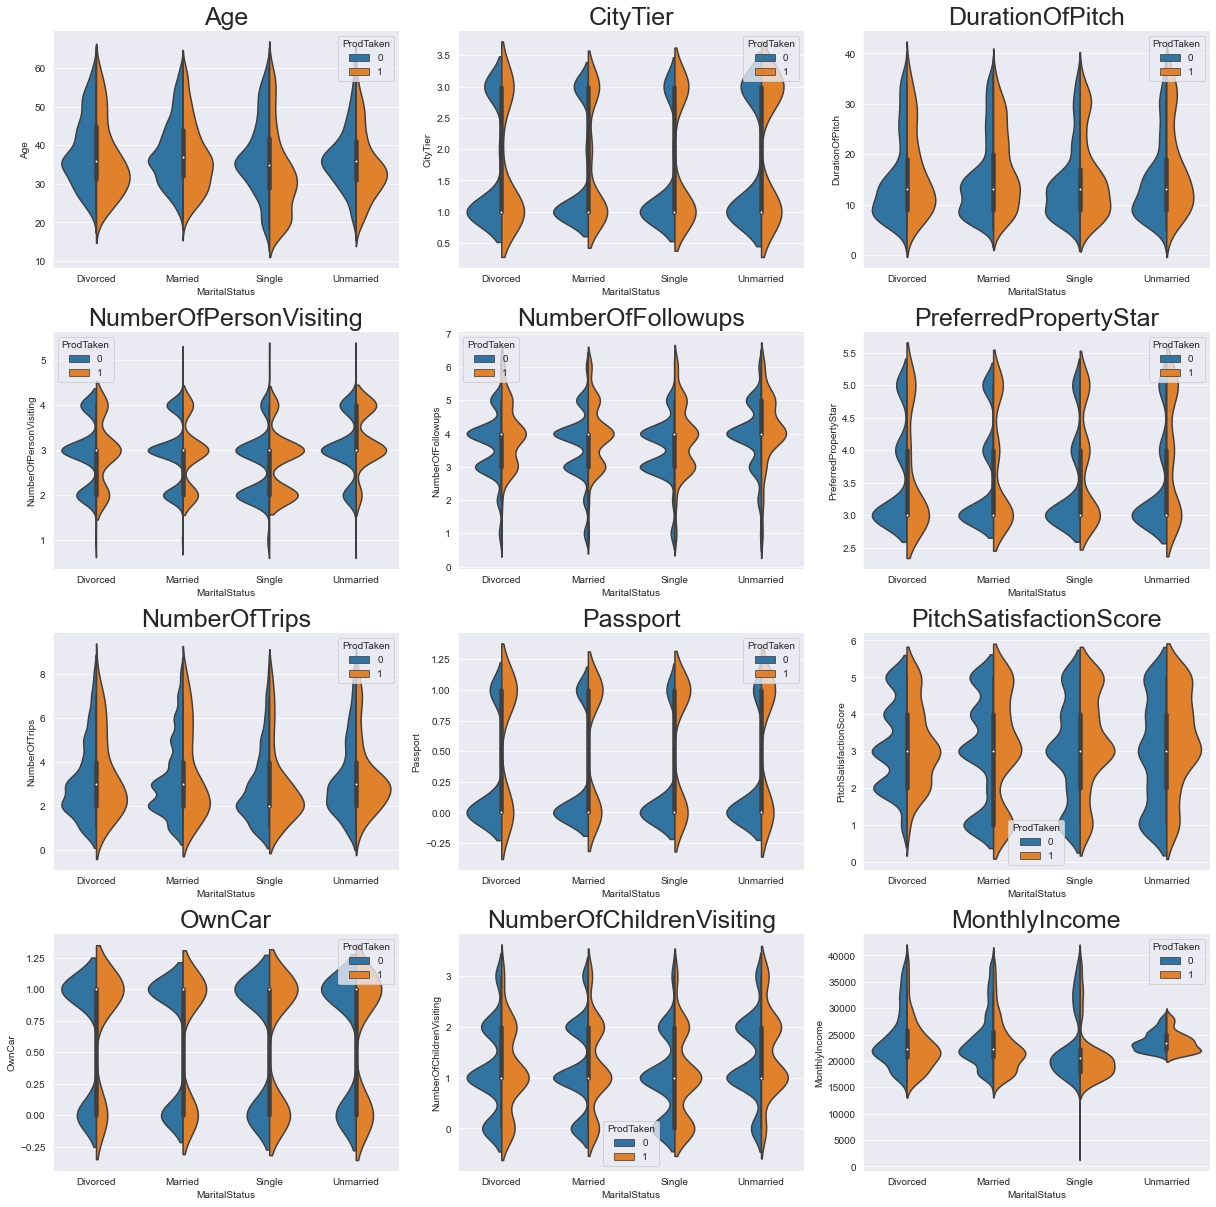

In [165]:
"""Does the Marital Status effect a customers purchase?"""
plt.figure(figsize=(17, 75))
for i in range(len(num_cols)):
    plt.subplot(18, 3, i + 1)
    sns.violinplot(data=df_eda, x='MaritalStatus', y=num_cols[i], hue="ProdTaken", split=True)
    plt.tight_layout()
    plt.title(num_cols[i], fontsize=25)
    sns.despine()

#### Notes
- Customers who purchase packages and are single, tend to be under 40.
- There is a similar, but not as noticable trend with regards to the unmarried.
- You can still the heavier weights on the distribution for customers who purchased a plan with regards to Duration of Pitch. That appears to be a consistent feature within the data.
- Unmarried are slightly more likely to purchase a package if that are coming with 3 or more people.

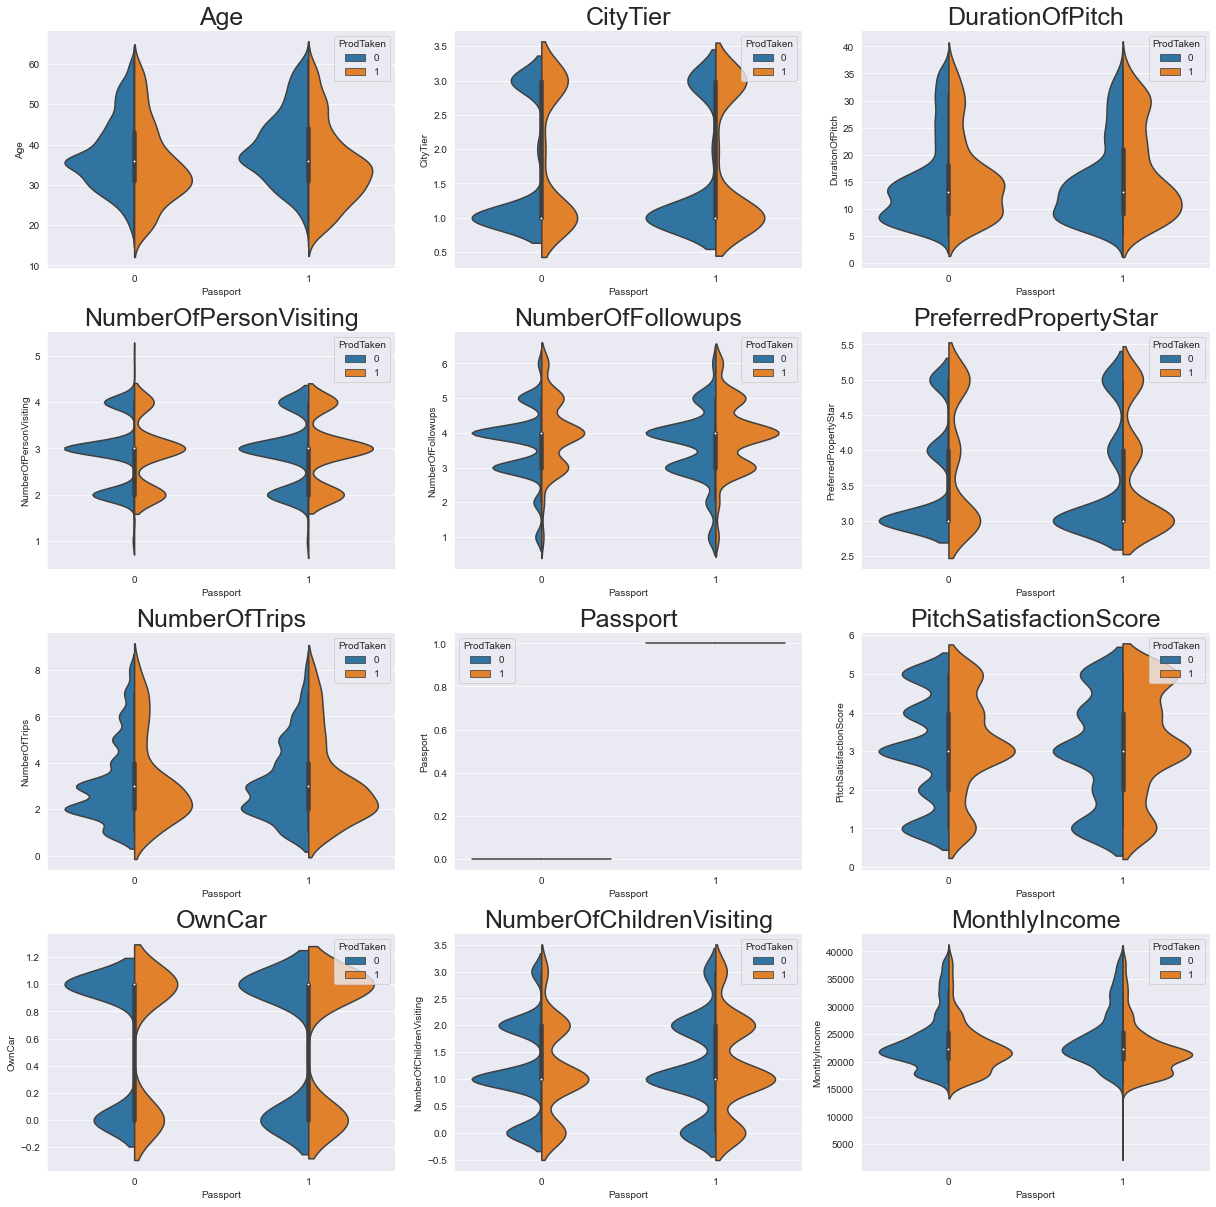

In [166]:
"""Does the ownership of a passport influence a customers purchase?"""
plt.figure(figsize=(17, 75))
for i in range(len(num_cols)):
    plt.subplot(18, 3, i + 1)
    sns.violinplot(data=df_eda, x='Passport', y=num_cols[i], hue="ProdTaken", split=True)
    plt.tight_layout()
    plt.title(num_cols[i], fontsize=25)
    sns.despine()

#### Notes
- The distributions generally appear to the same. There may be slighly more purchasing of passports across the board, but that trend does not seem to shift greatly based on any other features (the distributions do change dramatically from blue to orange in an one violin plot).

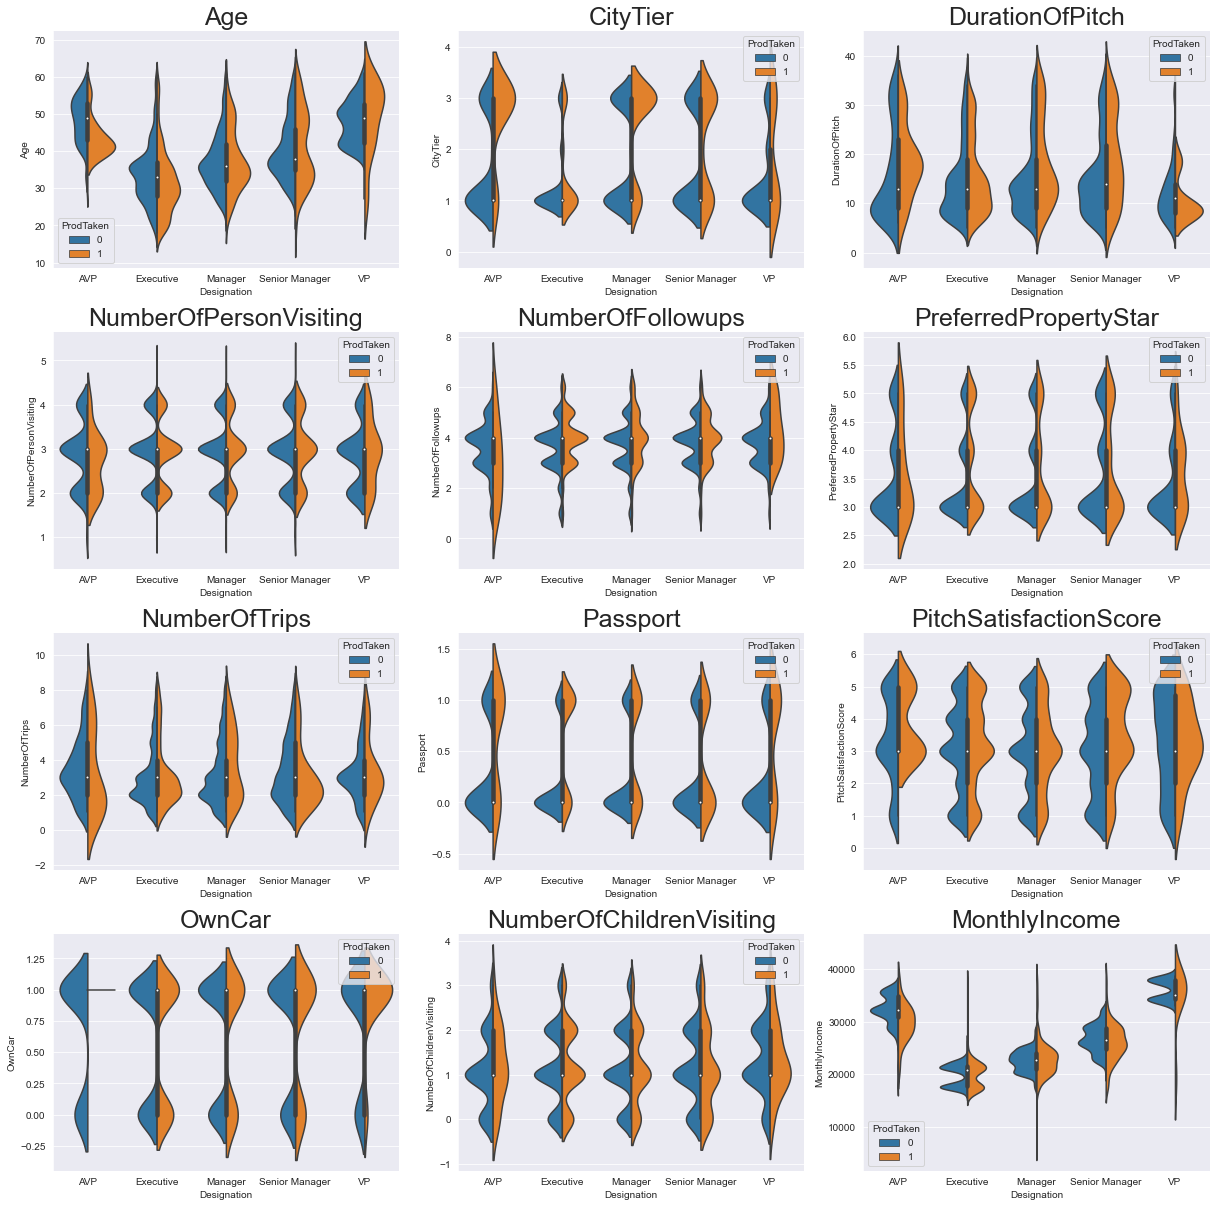

In [167]:
"""Does the designation of a customers job influence their purchase?"""
plt.figure(figsize=(17, 75))
for i in range(len(num_cols)):
    plt.subplot(18, 3, i + 1)
    sns.violinplot(data=df_eda, x='Designation', y=num_cols[i], hue="ProdTaken", split=True)
    plt.tight_layout()
    plt.title(num_cols[i], fontsize=25)
    sns.despine()

#### Notes
- Younger Assistant VPs (less than 50) are more likely to purchase a package.
- Older VPs (greater than 50) are more likely to purchase a package.
- Assistant VPs who purchase a plan show a prefernence for Tier 3 cities.
- Few of any group are interested in Tier 2 cities (This is actually true in all plots so far.)
- Assistant VPs appear who purchase a product prefer longer pitches. There is some evidence of a preference for this across designations, but it is a bit more marked with Assistant VPs in this case.
- Monthly Income varies by designation as you would expect, but there doesn't appear to any dramatic shifts in income within any one group for those who do or don't purchase a plan.


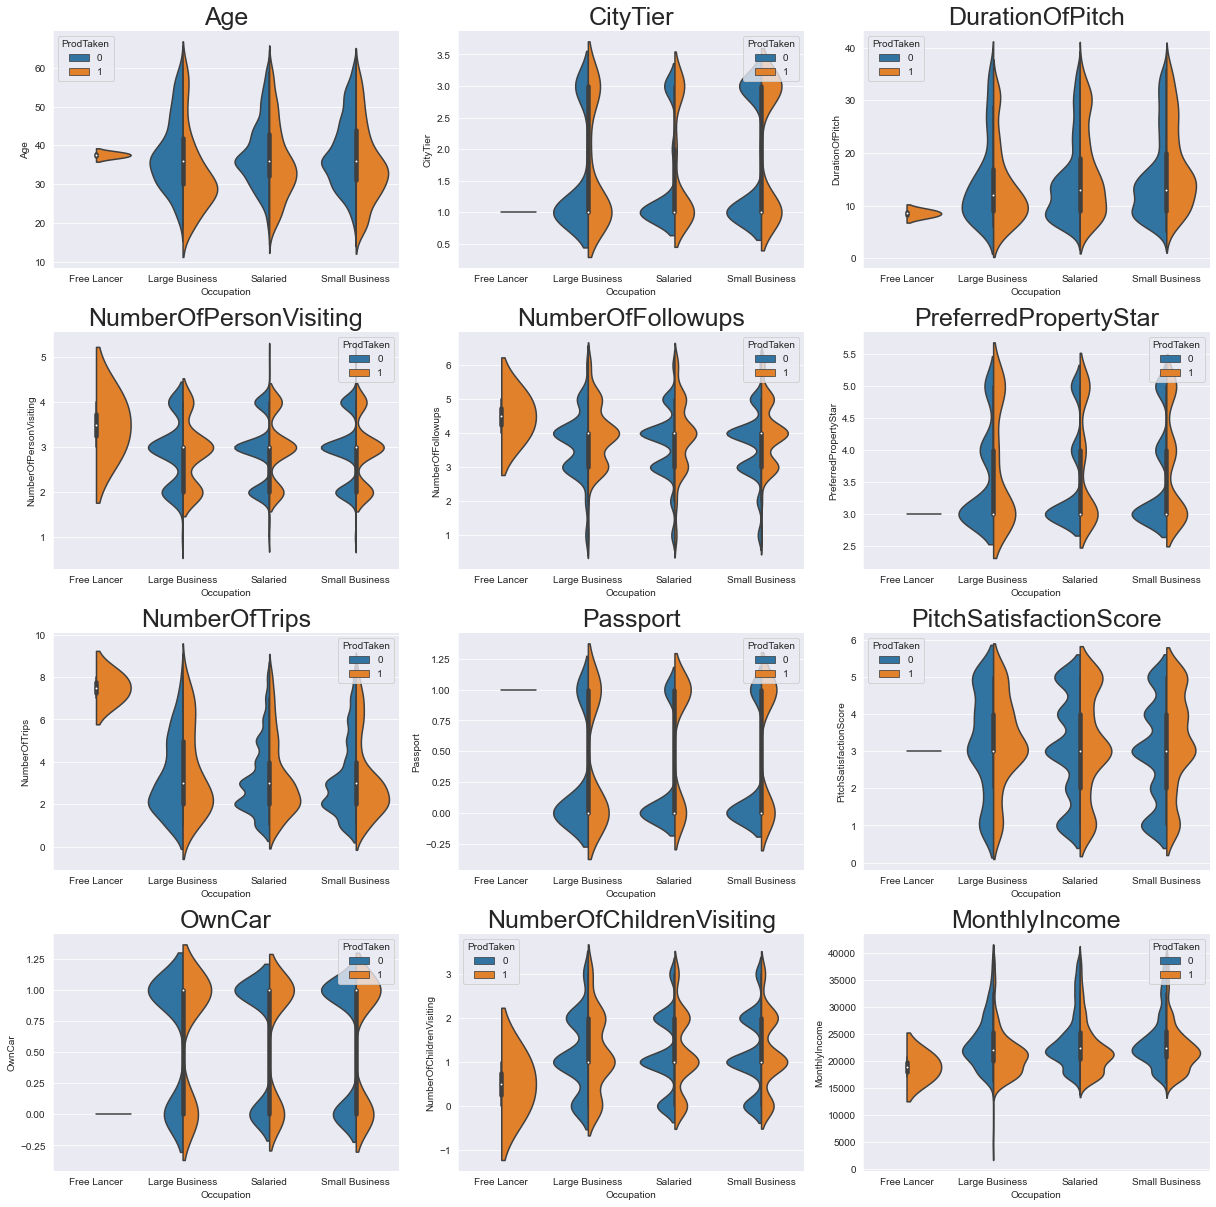

In [168]:
"""Does the occupation influence a customers purchase?"""
plt.figure(figsize=(17, 75))
for i in range(len(num_cols)):
    plt.subplot(18, 3, i + 1)
    sns.violinplot(data=df_eda, x='Occupation', y=num_cols[i], hue="ProdTaken", split=True)
    plt.tight_layout()
    plt.title(num_cols[i], fontsize=25)
    sns.despine()

#### Notes
- Freelance data should largely be disregarded in these plots. There are only two in the dataset and both purchased. it is simply too small a sample to know if any trend from 2 individuals has any meaning.
- There is a slight shift to younger individuals across all occupations for customers who did purchase a plan.
- The same slightly heavier weight for duration of pitch across all occupatoins for individuals who purchased a plan is present here as well.

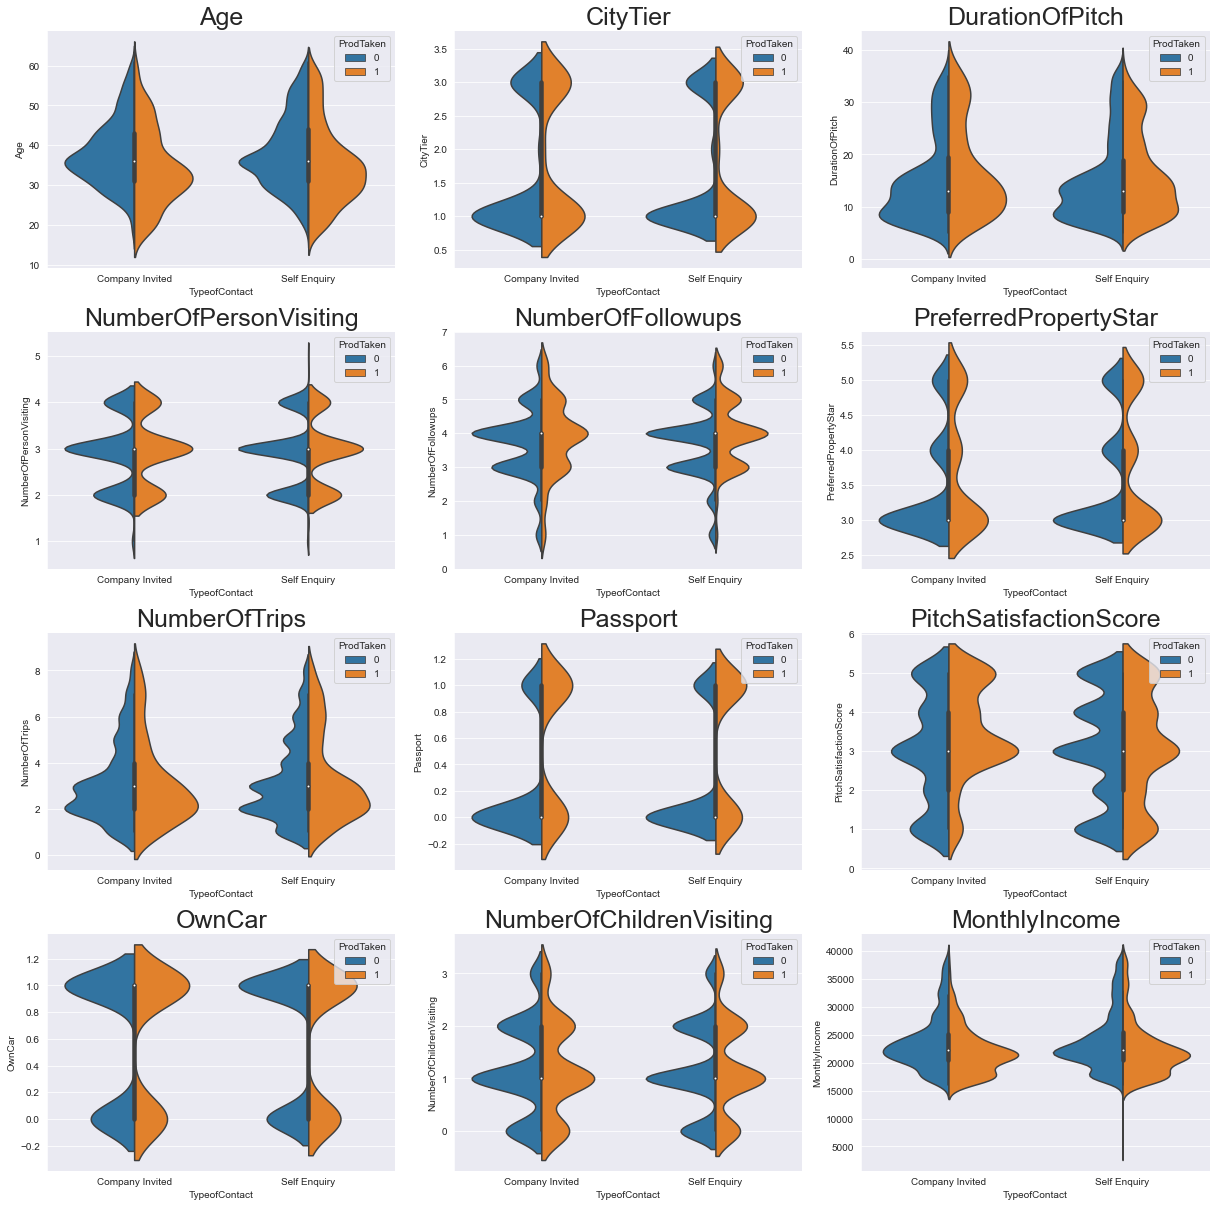

In [169]:
"""Does the whether the company contacted a customers influence their purchase?"""
plt.figure(figsize=(17, 75))
for i in range(len(num_cols)):
    plt.subplot(18, 3, i + 1)
    sns.violinplot(data=df_eda, x='TypeofContact', y=num_cols[i], hue="ProdTaken", split=True)
    plt.tight_layout()
    plt.title(num_cols[i], fontsize=25)
    sns.despine()

#### Notes
- Younger individuals are more likely to purchase again, regardless of how they were contacted. The same is true with duration of pitch, it tends to lead to more purchasing of travel plans.
- Few people are interested in Tier 2 Cities


## Modeling
#### Data is not all numerical, therefore a classification model is required. Will need to examine whether a logistic regression analysis may be suitable with regards to the target *ProdTaken*. If not, Decision Tree models will work best for this dataset.

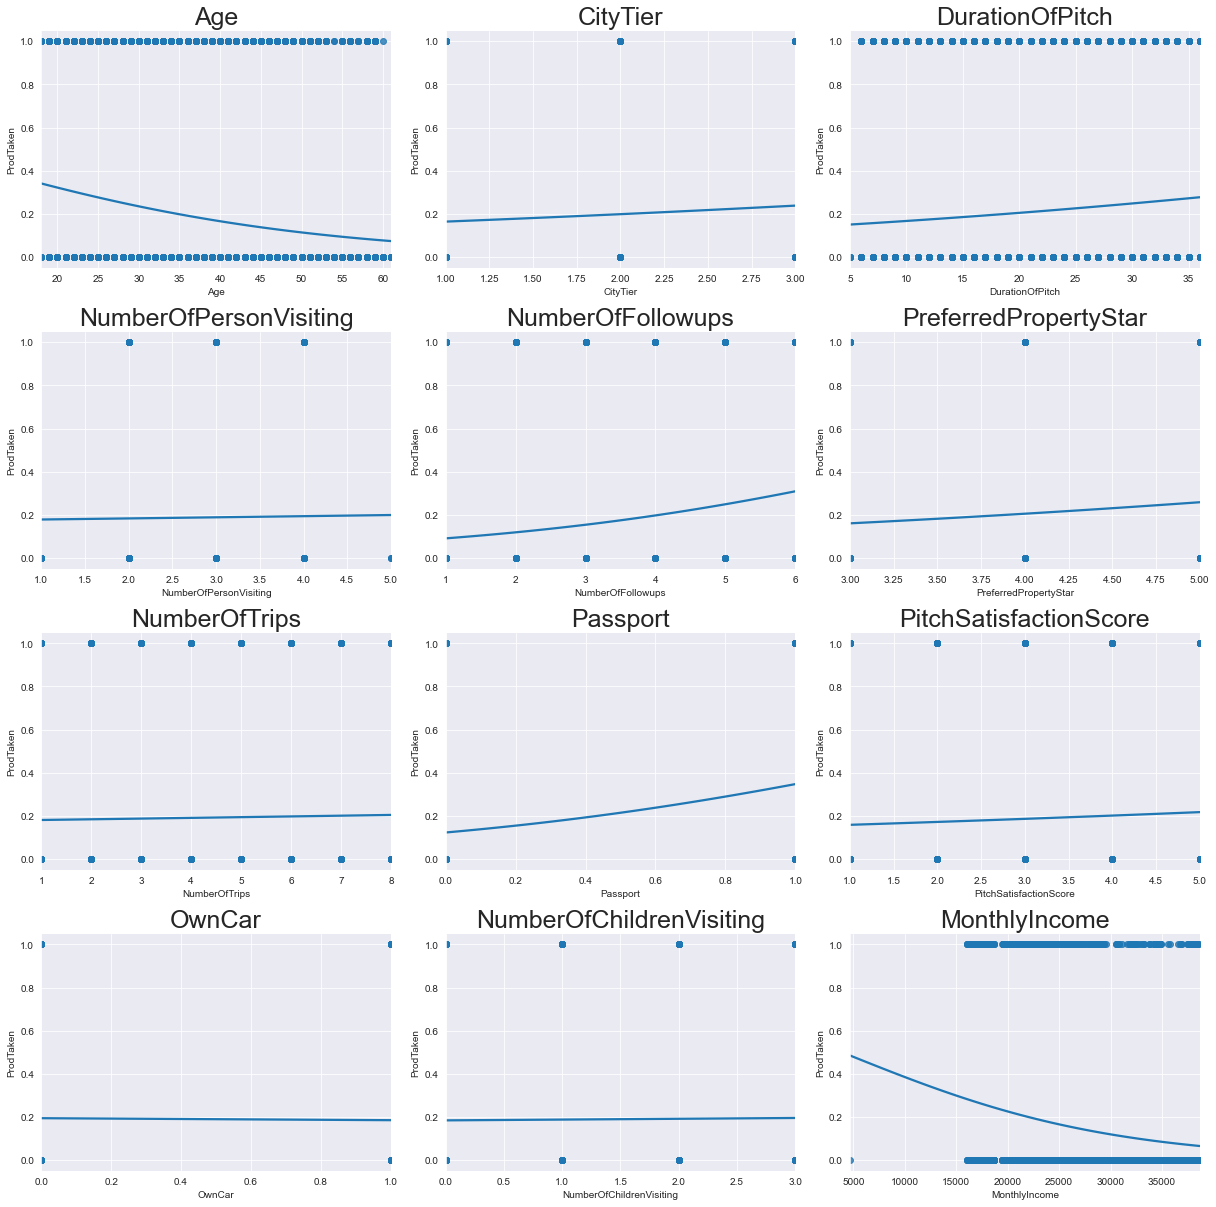

In [63]:
# Assess all relationships with regards to the target variable (Personal Loan)
num_cols = df_eda.select_dtypes(include=np.number).columns.tolist()
num_cols.remove("ProdTaken")
plt.figure(figsize=(17, 75))

for i in range(len(num_cols)):
    plt.subplot(18, 3, i + 1)
    sns.regplot(data=df_eda, x = num_cols[i], y = "ProdTaken", logistic=True, ci=None)
    plt.tight_layout()
    plt.title(num_cols[i], fontsize=25)
    sns.despine()

plt.show()

#### Notes
The trends on the data with regards to having logistical regression trends is either absent or weak across the variables. **Decision Tree Models will be used for this analysis.**

### Target Metric for models
**Recall is the primary target metric for these models.** This will optimize for ensuring a customer likely to purchase a plan is pursued, as opposed to missing out on some of those potential customers in favor of being more confident each customer we contact will purchase a travel plan.

In [64]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = metrics.accuracy_score(target, pred)  # to compute Accuracy
    recall = metrics.recall_score(target, pred)  # to compute Recall
    precision = metrics.precision_score(target, pred)  # to compute Precision
    f1 = metrics.f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
        },
        index=[0],
    )

    return df_perf

In [65]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = metrics.confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [66]:
df_model = df_eda.copy() #create new dataframe for modeling

In [67]:
"""Prepare dataset for modeling and split into testing and training"""
df_model = pd.get_dummies(df_model, drop_first=True) # One-hot encode all categorical variables
X = df_model.drop('ProdTaken', axis=1) # Separate data from target variable
Y = df_model.ProdTaken # Extract target variable

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y) # Split dataset for training and testing

In [68]:
# initialize dataframes for training and test performance data
model_train_perf = pd.DataFrame(index=["Accuracy", "Recall", "Precision", "F1"])
model_test_perf = pd.DataFrame(index=["Accuracy", "Recall", "Precision", "F1"])

### Decision Tree Model

In [69]:
"""Initialize and run basic decision tree model model"""
dtree = tree.DecisionTreeClassifier(criterion="gini", class_weight={0:0.19, 1:0.81}, random_state=42)
dtree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.19, 1: 0.81}, random_state=42)

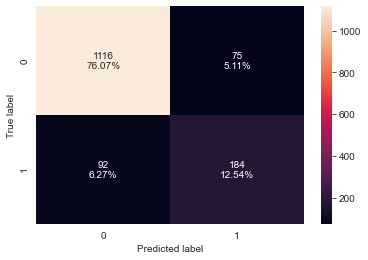

In [70]:
confusion_matrix_sklearn(dtree, x_test, y_test)

In [71]:
model_train_perf['Decision Tree'] = model_performance_classification_sklearn(dtree, x_train, y_train).T
model_performance_classification_sklearn(dtree, x_train, y_train)

Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0

In [72]:
model_test_perf['Decision Tree'] = model_performance_classification_sklearn(dtree, x_test, y_test).T
model_performance_classification_sklearn(dtree, x_test, y_test)

Accuracy    Recall  Precision       F1
0  0.886162  0.666667   0.710425  0.68785

#### Notes
- Basic Decision tree has very overfitting present as you would expect.
- Will need to do some pre-pruning

In [73]:
"""Run Decision tree model agian, but with pre-pruning"""
est = tree.DecisionTreeClassifier(criterion='gini', class_weight={0:0.19, 1:0.81}, random_state=42) # Choose classifier type for grid

# Set the grid parameters to test
params = {
        "max_depth": np.arange(2, 8),
        "min_samples_leaf": np.arange(1, 6),
        "max_leaf_nodes":np.arange(8, 16)
        }

# Score to compare params on
acc_scorer = metrics.make_scorer(metrics.recall_score)

#Run grid search
grid = GridSearchCV(est, params, scoring=acc_scorer, cv=5)
grid = grid.fit(x_train, y_train)

est = grid.best_estimator_ # Set clf to best combination of params
est.fit(x_train, y_train) # Fit best algorithm



DecisionTreeClassifier(class_weight={0: 0.19, 1: 0.81}, max_depth=7,
                       max_leaf_nodes=15, random_state=42)

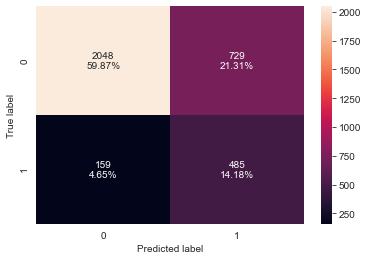

In [74]:
confusion_matrix_sklearn(est, x_train, y_train)

In [75]:
model_train_perf["Decision Tree Pre-pruned"] = model_performance_classification_sklearn(est, x_train, y_train).T
model_performance_classification_sklearn(est, x_train, y_train)

Accuracy    Recall  Precision        F1
0  0.740427  0.753106   0.399506  0.522067

In [76]:
model_test_perf["Decision Tree Pre-pruned"] = model_performance_classification_sklearn(est, x_test, y_test).T
model_performance_classification_sklearn(est, x_test, y_test)

Accuracy   Recall  Precision        F1
0  0.703476  0.65942   0.347992  0.455569

#### Notes
- Using pre-pruning we have improved the decision tree in the model in the sense that the Recall in both testing and training are now more similar. In addition, only the Recall, what we wish to focus on is now higher than the Precision. However, the Precision is quite bad at 37.4% in the testing, while the Recall is around 69%. Not great for either, but the removal of most of the overfitting is an improvement.
- Will carry out post pruning to see how much we can improve the Recall for a single model, but difficulty suggests Ensemble methods will be needed.

In [77]:
"""Prune tree based on performance in Recall, post-pruning"""
clf = tree.DecisionTreeClassifier(criterion='gini', class_weight={0:0.19, 1:0.81}, random_state=42) # Initialize new tree model
path = clf.cost_complexity_pruning_path(x_train, y_train) # Create pruning path based on training dataset
ccp_alphas, impurities = path.ccp_alphas, path.impurities # Extract alphas and impurites

# Run decision trees with each alpha
clfs = []
for i in ccp_alphas:
    clf = tree.DecisionTreeClassifier(criterion='gini', class_weight={0:0.19, 1:0.81}, random_state=42, ccp_alpha = i)
    clf.fit(x_train, y_train)
    clfs.append(clf)
print(f"Number of nodes in the last tree is {clfs[-1].tree_.node_count} with a ccp_alpha of {ccp_alphas[-1]}")

train_recalls = []
for i in clfs:
    pred_train = i.predict(x_train)
    values_train = metrics.recall_score(y_train, pred_train)
    train_recalls.append(values_train)
    
test_recalls = []
for i in clfs:
    pred_test = i.predict(x_test)
    values_test = metrics.recall_score(y_test, pred_test)
    test_recalls.append(values_test)


Number of nodes in the last tree is 1 with a ccp_alpha of 0.05304670128294986


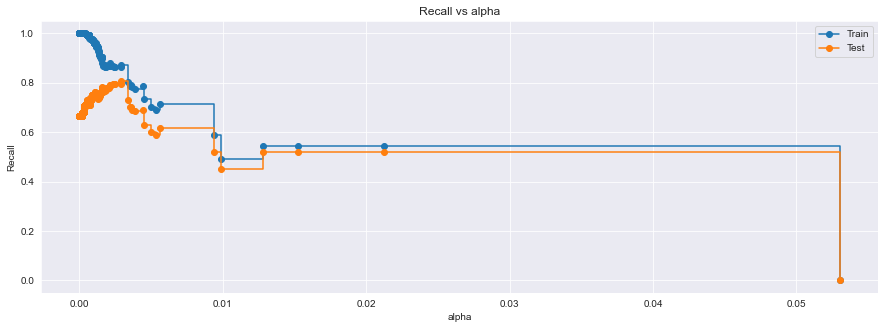

In [78]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(ccp_alphas, train_recalls, marker='o', label='Train', drawstyle='steps-post')
ax.plot(ccp_alphas, test_recalls, marker='o', label='Test', drawstyle='steps-post')
ax.set_xlabel("alpha")
ax.set_ylabel("Recall")
ax.set_title("Recall vs alpha")
ax.legend()
plt.show()

In [79]:
alpha_diffs = np.subtract(train_recalls, test_recalls) # Find difference between alphas
diffs = pd.Series(alpha_diffs)
idx = diffs[diffs < 0.1].index # Find indices for values with low difference, testing performs only slightly better on Recall than training
idx
train_recalls = np.array(train_recalls)
test_recalls = np.array(test_recalls)
pd.DataFrame([train_recalls[idx], test_recalls[idx], ccp_alphas[idx]], index=["Train", "Test", "Alpha"], columns=idx) # Format results for comparison

240       241       242       243       244       245       246  \
Train  0.871118  0.863354  0.864907  0.868012  0.868012  0.868012  0.868012   
Test   0.775362  0.768116  0.771739  0.775362  0.778986  0.778986  0.778986   
Alpha  0.001771  0.001830  0.001857  0.001864  0.001895  0.001985  0.002105   

            247       248       249       250       251       252       253  \
Train  0.878882  0.871118  0.868012  0.868012  0.869565  0.864907  0.864907   
Test   0.789855  0.789855  0.789855  0.789855  0.793478  0.793478  0.793478   
Alpha  0.002136  0.002151  0.002221  0.002246  0.002349  0.002411  0.002510   

            254       255       256       257       258       259       260  \
Train  0.864907  0.872671  0.804348  0.788820  0.791925  0.781056  0.776398   
Test   0.793478  0.807971  0.728261  0.702899  0.702899  0.688406  0.684783   
Alpha  0.002934  0.002935  0.003366  0.003539  0.003580  0.003662  0.003896   

            261       263       265       266       267       268       269  \
Train  0.787267  0.700311  0.715839  0.590062  0.492236  0.545031  0.545031   
Test   0.688406  0.601449  0.615942  0.521739  0.452899  0.518116  0.518116   
Alpha  0.004468  0.005028  0.005598  0.009397  0.009864  0.012836  0.015233   

            270       271  
Train  0.545031  0.000000  
Test   0.518116  0.000000  
Alpha  0.021235  0.053047

#### Notes
- There are nointersections, but you can see where the performance is close and better for testing. Based on the alphas where Testing performs better than training **the best recall in testing, that performs similarly in training, is with an alpha of 0.002786.** An index of 249 for model.

In [80]:
opt_dtree = clfs[249]
opt_dtree

DecisionTreeClassifier(ccp_alpha=0.002221168372204777,
                       class_weight={0: 0.19, 1: 0.81}, random_state=42)

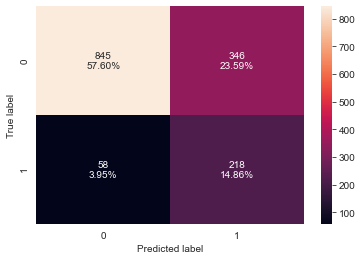

In [81]:
confusion_matrix_sklearn(opt_dtree, x_test, y_test)

In [82]:
model_train_perf["Decision Tree Post-pruned"] = model_performance_classification_sklearn(opt_dtree, x_train, y_train).T
model_performance_classification_sklearn(opt_dtree, x_train, y_train)

Accuracy    Recall  Precision        F1
0  0.782227  0.868012   0.458573  0.600107

In [83]:
model_test_perf["Decision Tree Post-pruned"] = model_performance_classification_sklearn(opt_dtree, x_test, y_test).T
model_performance_classification_sklearn(opt_dtree, x_test, y_test)

Accuracy    Recall  Precision        F1
0  0.724608  0.789855   0.386525  0.519048

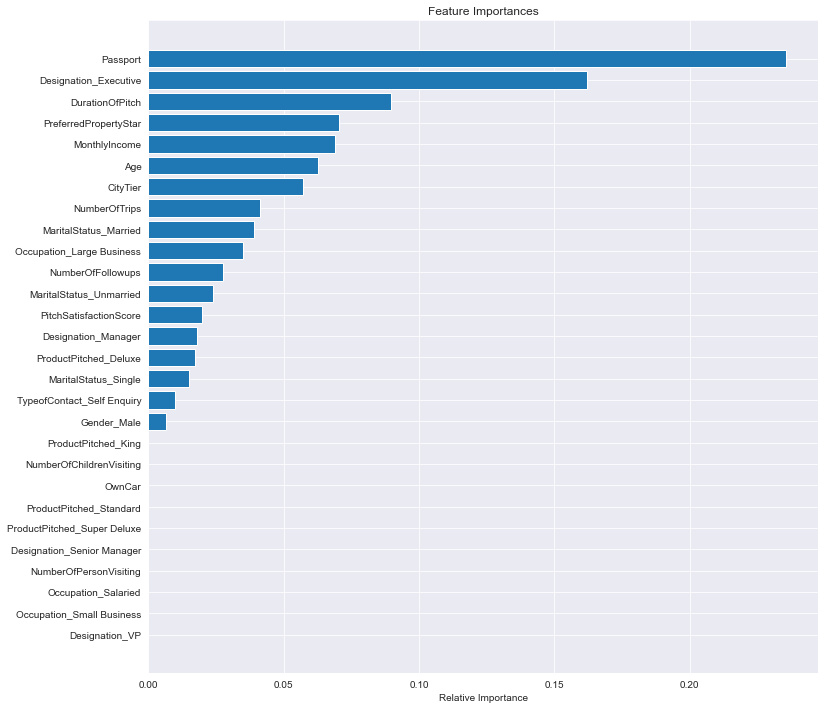

In [84]:
"""Examine the important features for this model"""
feature_names = x_train.columns
importances = opt_dtree.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#### Notes
- This added a little benefit over the pre-pruning. There may still be some overfitting due to higher values across the board on the training set. Importantly this did improve the Recall up to 78.5% for testing, but did not improve Precision much (39.4%). The poor precision is particularly concerning on these models even if we are attempting to prioritize Recall.
- Ensemble methods will be used to improve the recall
- With regards to importance this model finds the top 3 most important features to be a passport, followed by being an executive, and last the duration of the pitch.


### Bagging Ensemble

In [85]:
baggins = BaggingClassifier(random_state=42)
baggins.fit(x_train, y_train)

BaggingClassifier(random_state=42)

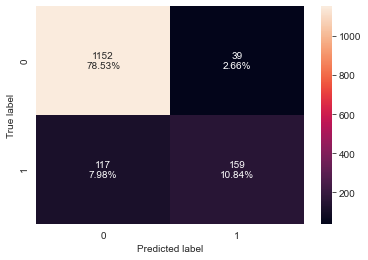

In [86]:
confusion_matrix_sklearn(baggins, x_test, y_test)

In [87]:
model_train_perf["Bagging"] = model_performance_classification_sklearn(baggins, x_train, y_train).T
model_performance_classification_sklearn(baggins, x_train, y_train)

Accuracy    Recall  Precision        F1
0  0.991815  0.958075   0.998382  0.977813

In [88]:
model_test_perf["Bagging"] = model_performance_classification_sklearn(baggins, x_test, y_test).T
model_performance_classification_sklearn(baggins, x_test, y_test)

Accuracy    Recall  Precision        F1
0  0.893661  0.576087    0.80303  0.670886

#### Notes
- A basic bagging classifier model is overfitting to the data as it performs much better on training than testing.
- However, the target variable is assymetric so adding weight to the model may assist.

In [89]:
baggins_wt = BaggingClassifier(base_estimator=tree.DecisionTreeClassifier(criterion='gini', class_weight={0:0.19, 1:0.81}, random_state=42))
baggins_wt.fit(x_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight={0: 0.19,
                                                                      1: 0.81},
                                                        random_state=42))

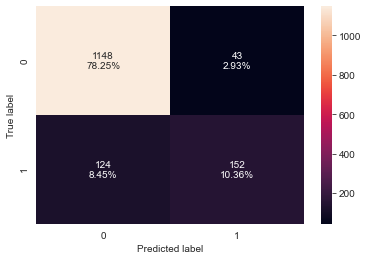

In [90]:
confusion_matrix_sklearn(baggins_wt, x_test, y_test)

In [91]:
model_train_perf["Bagging Weighted"] = model_performance_classification_sklearn(baggins_wt, x_train, y_train).T
model_performance_classification_sklearn(baggins_wt, x_train, y_train)

Accuracy    Recall  Precision       F1
0  0.993569  0.967391   0.998397  0.98265

In [92]:
model_test_perf["Bagging Weighted"] = model_performance_classification_sklearn(baggins_wt, x_test, y_test).T
model_performance_classification_sklearn(baggins_wt, x_test, y_test)

Accuracy    Recall  Precision        F1
0  0.886162  0.550725   0.779487  0.645435

#### Notes
- The bagging classifier, with weighting, is still quite overfit.
- Will need to tune using a grid search

In [93]:
# Initial Parameter search
tree_class = tree.DecisionTreeClassifier(criterion='gini', class_weight={0:0.19, 1:0.81}, random_state=42)
params = {
        'base_estimator':[tree_class],
        'n_estimators': [5, 10, 15, 20, 25, 50, 100, 150],
        'max_features': [0.5, 0.6, 0.7, 0.8, 0.9, 1]
        }

grid = GridSearchCV(BaggingClassifier(random_state=42, bootstrap=True), param_grid=params, scoring='recall', cv=5)
grid.fit(x_train, y_train)
grid.best_estimator_

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight={0: 0.19,
                                                                      1: 0.81},
                                                        random_state=42),
                  max_features=1, n_estimators=150, random_state=42)

In [94]:
# Fine tune parameter search for n_estimators
tree_class = tree.DecisionTreeClassifier(criterion='gini', class_weight={0:0.19, 1:0.81}, random_state=42)
params = {
        'base_estimator':[tree_class],
        'n_estimators': np.arange(10, 21),
        'max_features': [0.5, 0.6, 0.7, 0.8, 0.9, 1]
        }

grid = GridSearchCV(BaggingClassifier(random_state=42, bootstrap=True), param_grid=params, scoring='recall', cv=5)
grid.fit(x_train, y_train)
grid.best_estimator_

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight={0: 0.19,
                                                                      1: 0.81},
                                                        random_state=42),
                  max_features=0.9, n_estimators=17, random_state=42)

In [95]:
# Implement best estimated model
baggins_est = grid.best_estimator_
baggins_est.fit(x_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight={0: 0.19,
                                                                      1: 0.81},
                                                        random_state=42),
                  max_features=0.9, n_estimators=17, random_state=42)

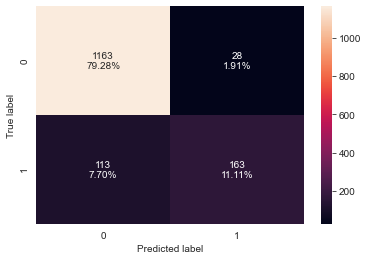

In [96]:
confusion_matrix_sklearn(baggins_est, x_test, y_test)

In [97]:
model_train_perf["Bagging Tuned"] = model_performance_classification_sklearn(baggins_est, x_train, y_train).T
model_performance_classification_sklearn(baggins_est, x_train, y_train)

Accuracy    Recall  Precision        F1
0  0.998831  0.993789        1.0  0.996885

In [98]:
model_test_perf["Bagging Tuned"] = model_performance_classification_sklearn(baggins_est, x_test, y_test).T
model_performance_classification_sklearn(baggins_est, x_test, y_test)

Accuracy   Recall  Precision        F1
0  0.903885  0.59058   0.853403  0.698073

#### Notes
- Even with tuning, the bagging ensemble has a significant amount of overfitting. Both the Recall and Precision have been improved slightly in testing, but we still have a very overfit model based on the much higher performance of the model on the training data.

### Random Forest Ensemble

In [99]:
ents = RandomForestClassifier(random_state=42)
ents.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

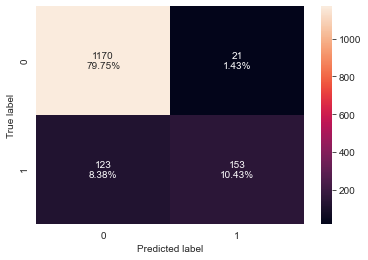

In [100]:
confusion_matrix_sklearn(ents, x_test, y_test)

In [101]:
model_train_perf["Random Forest"] = model_performance_classification_sklearn(ents, x_train, y_train).T
model_performance_classification_sklearn(ents, x_train, y_train)

Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0

In [102]:
model_test_perf["Random Forest"] = model_performance_classification_sklearn(ents, x_test, y_test).T
model_performance_classification_sklearn(ents, x_test, y_test)

Accuracy    Recall  Precision    F1
0   0.90184  0.554348    0.87931  0.68

#### Notes
- Massive overfitting as we would expect from a random forest model.
- Will add weighting before doing more extensive tuning

In [103]:
ents_wt = RandomForestClassifier(class_weight={0:0.19, 1:0.81}, random_state=42)
ents_wt.fit(x_train, y_train)

RandomForestClassifier(class_weight={0: 0.19, 1: 0.81}, random_state=42)

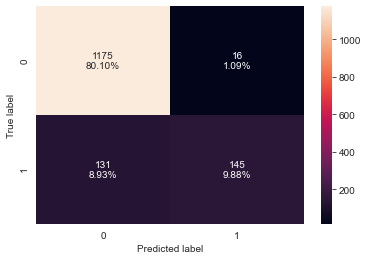

In [104]:
confusion_matrix_sklearn(ents_wt, x_test, y_test)

In [105]:
model_train_perf["Random Forest Weighted"] = model_performance_classification_sklearn(ents_wt, x_train, y_train).T
model_performance_classification_sklearn(ents_wt, x_train, y_train)

Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0

In [106]:
model_test_perf["Random Forest Weighted"] = model_performance_classification_sklearn(ents_wt, x_test, y_test).T
model_performance_classification_sklearn(ents_wt, x_test, y_test)

Accuracy    Recall  Precision        F1
0  0.899796  0.525362   0.900621  0.663616

#### Notes 
- As we would expect, still an extensive amount of overfitting here.
- Will tune the tree to see if we can remove an effective amount of the overfitting

In [107]:
ent_est = RandomForestClassifier(class_weight={0:0.19, 1:0.81}, random_state=42)

params = {
        "n_estimators": [5, 10, 15, 20, 25, 50, 100, 150],
        "min_samples_leaf": np.arange(1, 5),
        "max_features": [0.5, 0.6, 0.7, 0.8, 0.9, 1],
        "max_samples": [0.5, 0.6, 0.7, 0.8, 0.9, 1]
        }

grid = GridSearchCV(ent_est, params, scoring='recall', cv=5)
grid = grid.fit(x_train, y_train)
beep(sound=1)

In [108]:
grid.best_estimator_

RandomForestClassifier(class_weight={0: 0.19, 1: 0.81}, max_features=0.5,
                       max_samples=0.9, min_samples_leaf=4, n_estimators=10,
                       random_state=42)

In [109]:
ent_est = RandomForestClassifier(class_weight={0:0.19, 1:0.81}, random_state=42)

params = {
        "n_estimators": np.arange(10, 21),
        "min_samples_leaf": np.arange(1, 5),
        "max_features": [0.5, 0.6, 0.7, 0.8, 0.9, 1],
        "max_samples": [0.5, 0.6, 0.7, 0.8, 0.9, 1]
        }

grid = GridSearchCV(ent_est, params, scoring='recall', cv=5)
grid = grid.fit(x_train, y_train)
beep(sound=1)

In [110]:
grid.best_estimator_

RandomForestClassifier(class_weight={0: 0.19, 1: 0.81}, max_features=0.5,
                       max_samples=0.9, min_samples_leaf=4, n_estimators=17,
                       random_state=42)

In [111]:
# Implement best estimated model
ent_est = grid.best_estimator_
ent_est.fit(x_train, y_train)

RandomForestClassifier(class_weight={0: 0.19, 1: 0.81}, max_features=0.5,
                       max_samples=0.9, min_samples_leaf=4, n_estimators=17,
                       random_state=42)

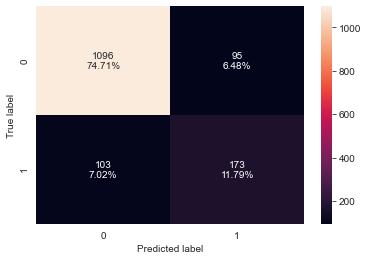

In [112]:
confusion_matrix_sklearn(ent_est, x_test,y_test)

In [113]:
model_train_perf["Random Forest Tuned"] = model_performance_classification_sklearn(ent_est, x_train, y_train).T
model_performance_classification_sklearn(ent_est, x_train, y_train)

Accuracy    Recall  Precision        F1
0  0.965215  0.944099   0.879884  0.910861

In [114]:
model_test_perf["Random Forest Tuned"] = model_performance_classification_sklearn(ent_est, x_test, y_test).T
model_performance_classification_sklearn(ent_est, x_test, y_test)

Accuracy    Recall  Precision        F1
0  0.865031  0.626812   0.645522  0.636029

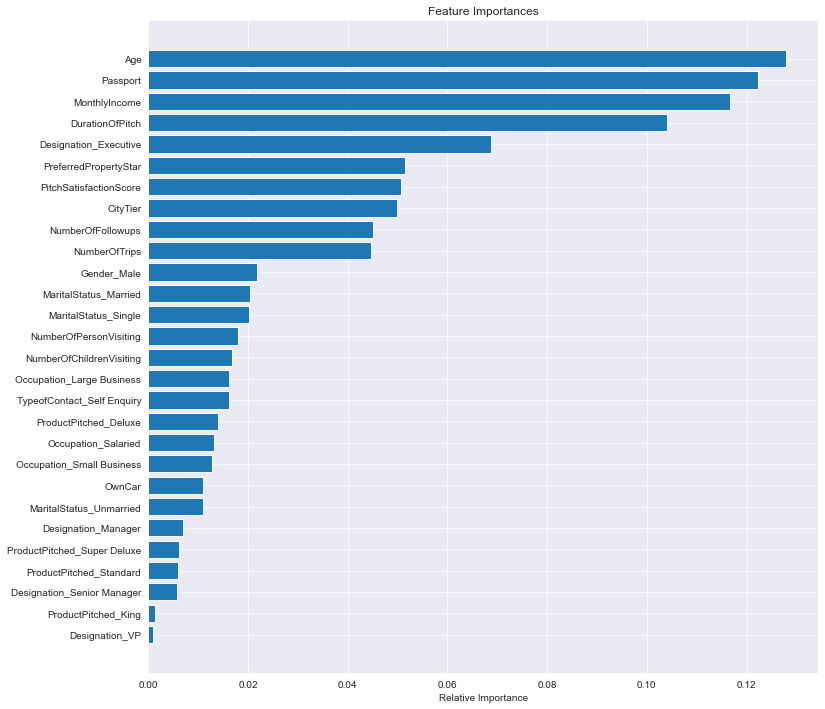

In [115]:
"""Examine the important features for this model"""
feature_names = x_train.columns
importances = ent_est.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#### Notes
- The tuning of the Random Forest has improved the model, but there is still a significant amount of overfitting with regards to the training data.
- With regards to importances this model finds the top 3 most important factors to be Passports, Age, and Duration of Pitch.

### AdaBoost Classifier

In [116]:
ab_class = AdaBoostClassifier(random_state=42)
ab_class.fit(x_train, y_train)

AdaBoostClassifier(random_state=42)

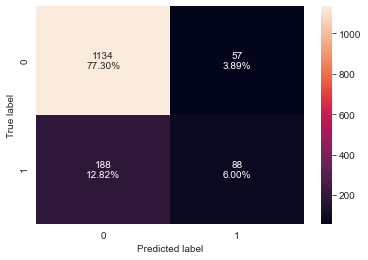

In [117]:
confusion_matrix_sklearn(ab_class, x_test,y_test)

In [118]:
model_train_perf["AdaBoost Classifier"] = model_performance_classification_sklearn(ab_class, x_train, y_train).T
model_performance_classification_sklearn(ab_class, x_train, y_train)

Accuracy    Recall  Precision        F1
0  0.856475  0.378882   0.728358  0.498468

In [119]:
model_test_perf["AdaBoost Classifier"] = model_performance_classification_sklearn(ab_class, x_test, y_test).T
model_performance_classification_sklearn(ab_class, x_test, y_test)

Accuracy    Recall  Precision        F1
0  0.832993  0.318841   0.606897  0.418052

#### Notes
- The AdaBoost ensemble avoids overfitting admirable, but it simply scores very poorly on Recall (31%).
- Will see if tuning can improve this

In [170]:
ab_tuned = AdaBoostClassifier(random_state=42, estimator_weights_=[0.19, 0.81])

params = {
        "n_estimators": np.arange(10, 21),
        "learning_rate": [1, 0.5, 0.1, 0.01]
        }

grid = GridSearchCV(ab_tuned, params, scoring='recall', cv=5)
grid = grid.fit(x_train, y_train)
beep(sound=1)

TypeError: __init__() got an unexpected keyword argument 'estimator_weights_'

In [ ]:
grid.best_estimator_

In [ ]:
ab_tuned = grid.best_estimator_
ab_tuned.fit(x_train, y_train)

In [ ]:
confusion_matrix_sklearn(ab_tuned, x_test,y_test)

In [ ]:
model_train_perf["AdaBoost Tuned"] = model_performance_classification_sklearn(ab_tuned, x_train, y_train).T
model_performance_classification_sklearn(ab_tuned, x_train, y_train)

In [ ]:
model_test_perf["AdaBoost Tuned"] = model_performance_classification_sklearn(ab_tuned, x_test, y_test).T
model_performance_classification_sklearn(ab_tuned, x_test, y_test)

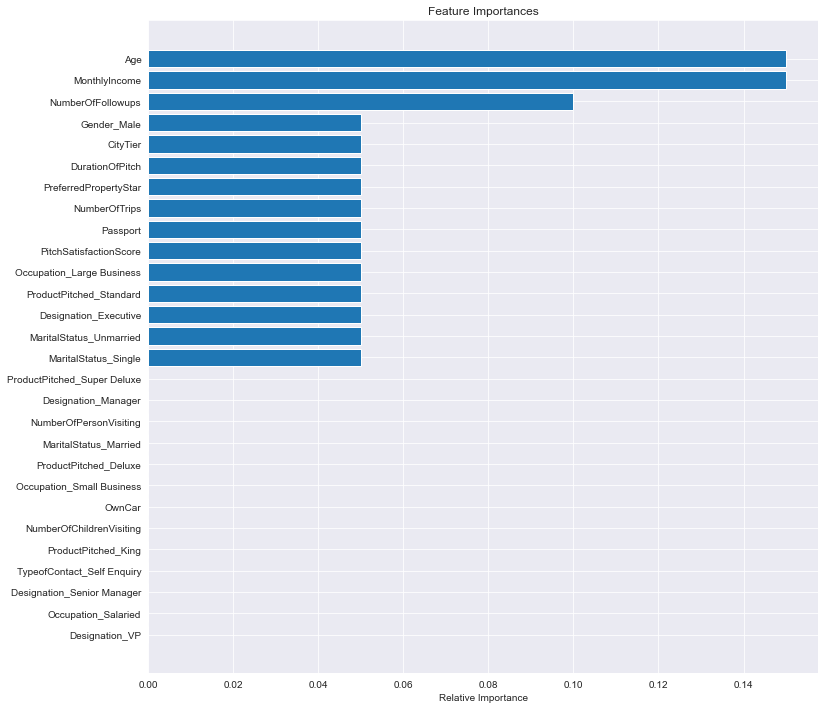

In [126]:
"""Examine the important features for this model"""
feature_names = x_train.columns
importances = ab_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#### Notes
- There is now even less overfitting in the model, the test and training performace are very close. However, the performance on recall in particular has actually dropped to 24.5%. It does better on other metrics, but as wel care about Recall more than the others we certainly need to explore further models.
- The top three features for importance to this model are Number of Follow-ups, Monthly Income, and City Tier.

### Gradient Boost

In [127]:
gb_est = GradientBoostingClassifier(random_state=42)
gb_est.fit(x_train, y_train)

GradientBoostingClassifier(random_state=42)

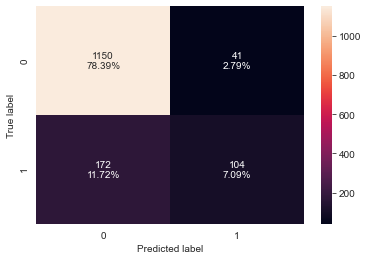

In [128]:
confusion_matrix_sklearn(gb_est, x_test,y_test)

In [129]:
model_train_perf["Gradient Boost"] = model_performance_classification_sklearn(gb_est, x_train, y_train).T
model_performance_classification_sklearn(gb_est, x_train, y_train)

Accuracy    Recall  Precision        F1
0  0.889798  0.503106   0.850394  0.632195

In [130]:
model_test_perf["Gradient Boost"] = model_performance_classification_sklearn(gb_est, x_test, y_test).T
model_performance_classification_sklearn(gb_est, x_test, y_test)

Accuracy    Recall  Precision        F1
0  0.854806  0.376812   0.717241  0.494062

#### Notes
- Ensemble model does limit the overfitting compared to some of the others, but similar to the AdaBoost it struggles for recall in general with a value of 36.9% on the testing dataset.
- Will need to see if tuning can improve this.


In [131]:
gb_tuned = GradientBoostingClassifier(random_state=42)

params = {
        "n_estimators": np.arange(10, 21),
        "subsample": [0.5, 0.6, 0.7, 0.8, 0.9, 1],
        "max_features": [0.5, 0.6, 0.7, 0.8, 0.9, 1],
        "max_depth": np.arange(2, 12, 2)
        }

grid = GridSearchCV(gb_tuned, params, scoring='recall', cv=5)
grid = grid.fit(x_train, y_train)
beep(sound=7)

In [132]:
grid.best_estimator_

GradientBoostingClassifier(max_depth=10, max_features=0.9, n_estimators=20,
                           random_state=42, subsample=1)

In [133]:
gb_tuned = GradientBoostingClassifier(random_state=42)

params = {
        "n_estimators": [20, 25, 50, 100, 150, 500],
        "subsample": [0.9, 1],
        "max_features": [0.8, 0.9, 1],
        "max_depth": np.arange(8, 12, 1)
        }

grid = GridSearchCV(gb_tuned, params, scoring='recall', cv=5)
grid = grid.fit(x_train, y_train)

beep(sound=7)

In [134]:
grid.best_estimator_

GradientBoostingClassifier(max_depth=10, max_features=0.8, n_estimators=500,
                           random_state=42, subsample=1)

In [135]:
gb_tuned = grid.best_estimator_
gb_tuned.fit(x_train, y_train)

GradientBoostingClassifier(max_depth=10, max_features=0.8, n_estimators=500,
                           random_state=42, subsample=1)

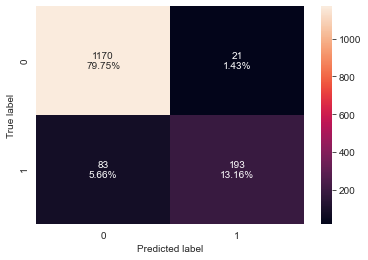

In [136]:
confusion_matrix_sklearn(gb_tuned, x_test,y_test)

In [137]:
model_train_perf["Gradient Boost Tuned"] = model_performance_classification_sklearn(gb_tuned, x_train, y_train).T
model_performance_classification_sklearn(gb_tuned, x_train, y_train)

Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0

In [138]:
model_test_perf["Gradient Boost Tuned"] = model_performance_classification_sklearn(gb_tuned, x_test, y_test).T
model_performance_classification_sklearn(gb_tuned, x_test, y_test)

Accuracy    Recall  Precision        F1
0  0.929107  0.699275   0.901869  0.787755

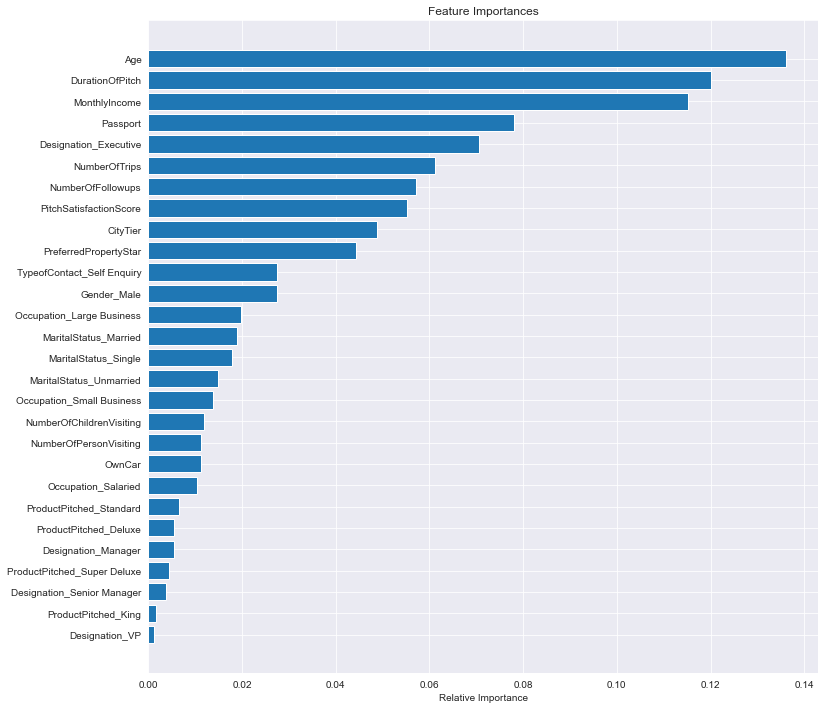

In [139]:
"""Examine the important features for this model"""
feature_names = x_train.columns
importances = gb_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#### Notes
- Tuning did increase the Recall (70.5%), however, it also seems to have increased the overfitting of the dataset as the Recall on the training set is now 100%!
- Will need to pursue other models.
- This model finds the top 3 most important features to be Age, Duration of Pitch, and Monthly Income

### XGBoost Classifier

In [140]:
xgb_est = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_est.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

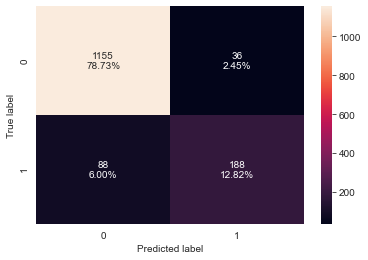

In [141]:
confusion_matrix_sklearn(xgb_est, x_test,y_test)

In [142]:
model_train_perf["XGBoost"] = model_performance_classification_sklearn(xgb_est, x_train, y_train).T
model_performance_classification_sklearn(xgb_est, x_train, y_train)

Accuracy    Recall  Precision        F1
0  0.999415  0.996894        1.0  0.998445

In [143]:
model_test_perf["XGBoost"] = model_performance_classification_sklearn(xgb_est, x_test, y_test).T
model_performance_classification_sklearn(xgb_est, x_test, y_test)

Accuracy    Recall  Precision     F1
0  0.915474  0.681159   0.839286  0.752

#### Notes
- Model performs fairly well on the testing set (72.3% on Recall) with fairly high scores across the board, however, the trainng scores are all near one and consistently higher suggestive of a fair amount of overfitting to the training set.
- Will need to see if tuning can solve some of the overfitting.

In [144]:
xgb_tuned = XGBClassifier(random_state=42, eval_metric='logloss')

params = {
        "n_estimators": np.arange(10, 21),
        "subsample": [0.5, 0.6, 0.7, 0.8, 0.9, 1],
        "gamma": [0, 1, 3, 5],
        "colsample_bytree":[0.5, 0.6, 0.7, 0.8, 0.9, 1],
        "colsample_bylevel":[0.5, 0.6, 0.7, 0.8, 0.9, 1]
        }

grid = GridSearchCV(xgb_tuned, params, scoring='recall', cv=5)
grid = grid.fit(x_train, y_train)
beep(sound=7)

In [145]:
grid.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, eval_metric='logloss',
              gamma=1, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=20, n_jobs=4,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.9, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [146]:
xgb_tuned = XGBClassifier(random_state=42, eval_metric='logloss')

params = {
        "n_estimators": [20, 25, 50, 100, 150, 500],
        "subsample": [0.8, 0.9, 1],
        "gamma": [0, 1, 2],
        "colsample_bytree":[0.8, 0.9, 1],
        "colsample_bylevel":[0.8, 0.9, 1]
        }

grid = GridSearchCV(xgb_tuned, params, scoring='recall', cv=5)
grid = grid.fit(x_train, y_train)
beep(sound=7)

In [147]:
grid.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=4,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.9, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [148]:
xgb_tuned = grid.best_estimator_
xgb_tuned.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=4,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.9, tree_method='exact',
              validate_parameters=1, verbosity=None)

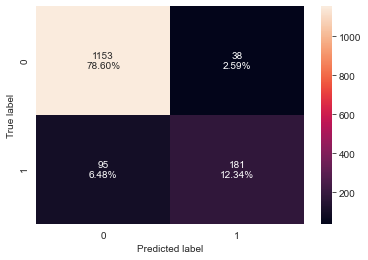

In [149]:
confusion_matrix_sklearn(xgb_tuned, x_test,y_test)

In [150]:
model_train_perf["XGBoost Tuned"] = model_performance_classification_sklearn(xgb_tuned, x_train, y_train).T
model_performance_classification_sklearn(xgb_tuned, x_train, y_train)

Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0

In [151]:
model_test_perf["XGBoost Tuned"] = model_performance_classification_sklearn(xgb_tuned, x_test, y_test).T
model_performance_classification_sklearn(xgb_tuned, x_test, y_test)

Accuracy    Recall  Precision        F1
0  0.909339  0.655797   0.826484  0.731313

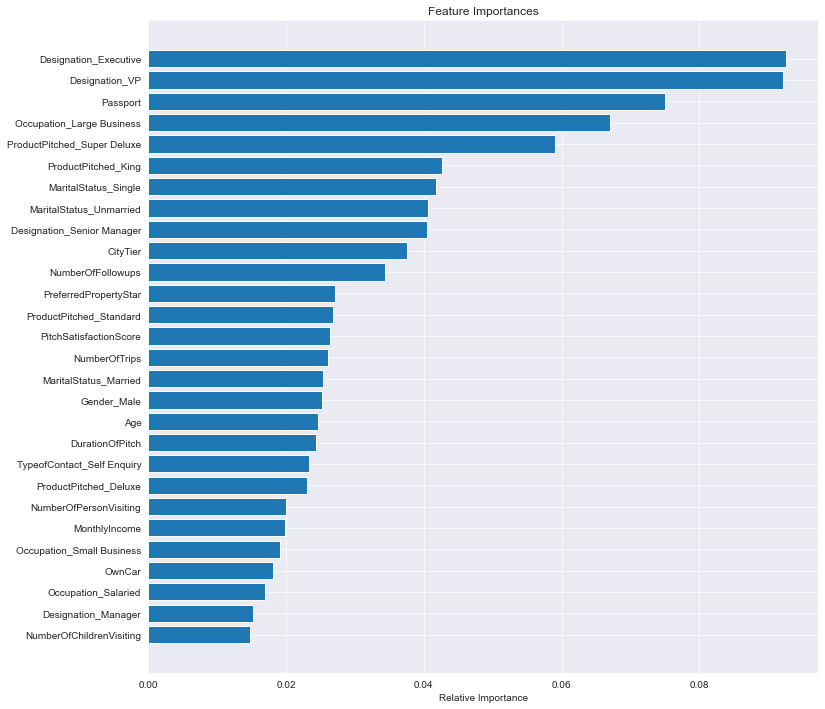

In [152]:
"""Examine the important features for this model"""
feature_names = x_train.columns
importances = xgb_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#### Notes
- Runing made some slight adjustments. It improved recall slightly in the test dataset, but did so by also improving the scores across the board on the training, so the overfitting problem has not been improved.
- For this model the top three most important features are Passport, being a Manager, and Being an Executive.

### Stacking Model
**Examine models up to this point to decide which to stack**

In [153]:
model_train_perf

Decision Tree  Decision Tree Pre-pruned  Decision Tree Post-pruned  \
Accuracy             1.0                  0.740427                   0.782227   
Recall               1.0                  0.753106                   0.868012   
Precision            1.0                  0.399506                   0.458573   
F1                   1.0                  0.522067                   0.600107   

            Bagging  Bagging Weighted  Bagging Tuned  Random Forest  \
Accuracy   0.991815          0.993569       0.998831            1.0   
Recall     0.958075          0.967391       0.993789            1.0   
Precision  0.998382          0.998397       1.000000            1.0   
F1         0.977813          0.982650       0.996885            1.0   

           Random Forest Weighted  Random Forest Tuned  AdaBoost Classifier  \
Accuracy                      1.0             0.965215             0.856475   
Recall                        1.0             0.944099             0.378882   
Precision                     1.0             0.879884             0.728358   
F1                            1.0             0.910861             0.498468   

           AdaBoost Tuned  Gradient Boost  Gradient Boost Tuned   XGBoost  \
Accuracy         0.845367        0.889798                   1.0  0.999415   
Recall           0.299689        0.503106                   1.0  0.996894   
Precision        0.712177        0.850394                   1.0  1.000000   
F1               0.421858        0.632195                   1.0  0.998445   

           XGBoost Tuned  
Accuracy             1.0  
Recall               1.0  
Precision            1.0  
F1                   1.0

In [154]:
model_test_perf

Decision Tree  Decision Tree Pre-pruned  Decision Tree Post-pruned  \
Accuracy        0.886162                  0.703476                   0.724608   
Recall          0.666667                  0.659420                   0.789855   
Precision       0.710425                  0.347992                   0.386525   
F1              0.687850                  0.455569                   0.519048   

            Bagging  Bagging Weighted  Bagging Tuned  Random Forest  \
Accuracy   0.893661          0.886162       0.903885       0.901840   
Recall     0.576087          0.550725       0.590580       0.554348   
Precision  0.803030          0.779487       0.853403       0.879310   
F1         0.670886          0.645435       0.698073       0.680000   

           Random Forest Weighted  Random Forest Tuned  AdaBoost Classifier  \
Accuracy                 0.899796             0.865031             0.832993   
Recall                   0.525362             0.626812             0.318841   
Precision                0.900621             0.645522             0.606897   
F1                       0.663616             0.636029             0.418052   

           AdaBoost Tuned  Gradient Boost  Gradient Boost Tuned   XGBoost  \
Accuracy         0.837764        0.854806              0.929107  0.915474   
Recall           0.268116        0.376812              0.699275  0.681159   
Precision        0.672727        0.717241              0.901869  0.839286   
F1               0.383420        0.494062              0.787755  0.752000   

           XGBoost Tuned  
Accuracy        0.909339  
Recall          0.655797  
Precision       0.826484  
F1              0.731313

**The models with the least overfitting for each type of model that can work in for Stacking are:**
- Post-Pruned decision tree
- Random Forest Tuned
- Gradient Boost (The Tuned verision actually led to major overfitting of the training data, untuned)

**These models will be included in the stacking model with the XGBoost as the final estimator.**

In [155]:
estimators = [('Decision Tree', opt_dtree), ('Random Forest', ent_est), ('Gradient Boosting', gb_est)]
final_est = XGBClassifier(random_state=42, eval_metric='logloss')

In [156]:
stacking_est = StackingClassifier(estimators=estimators, final_estimator=final_est, cv=5)
stacking_est.fit(x_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('Decision Tree',
                                DecisionTreeClassifier(ccp_alpha=0.002221168372204777,
                                                       class_weight={0: 0.19,
                                                                     1: 0.81},
                                                       random_state=42)),
                               ('Random Forest',
                                RandomForestClassifier(class_weight={0: 0.19,
                                                                     1: 0.81},
                                                       max_features=0.5,
                                                       max_samples=0.9,
                                                       min_samples_leaf=4,
                                                       n_estimators=17,
                                                       random_state=42)),
                               ('Gra

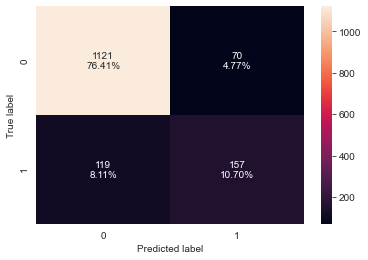

In [157]:
confusion_matrix_sklearn(stacking_est, x_test,y_test)

In [158]:
model_train_perf["Stacking"] = model_performance_classification_sklearn(stacking_est, x_train, y_train).T
model_performance_classification_sklearn(stacking_est, x_train, y_train)

Accuracy    Recall  Precision        F1
0  0.955569  0.869565    0.89172  0.880503

In [159]:
model_test_perf["Stacking"] = model_performance_classification_sklearn(stacking_est, x_test, y_test).T
model_performance_classification_sklearn(stacking_est, x_test, y_test)

Accuracy    Recall  Precision        F1
0  0.871166  0.568841    0.69163  0.624254

#### Notes
- The stacking ensemble, built from the previous, follows a similar pattern. The ability to be sure which customer will purchase a package appears to be difficult based on the given data. The recall, can be higher than seen in this model, but most models regardless of the value appear to maintian a decent amount of noise that is difficult to filter.

### Comparison of all models performances

In [160]:
model_train_perf

Decision Tree  Decision Tree Pre-pruned  Decision Tree Post-pruned  \
Accuracy             1.0                  0.740427                   0.782227   
Recall               1.0                  0.753106                   0.868012   
Precision            1.0                  0.399506                   0.458573   
F1                   1.0                  0.522067                   0.600107   

            Bagging  Bagging Weighted  Bagging Tuned  Random Forest  \
Accuracy   0.991815          0.993569       0.998831            1.0   
Recall     0.958075          0.967391       0.993789            1.0   
Precision  0.998382          0.998397       1.000000            1.0   
F1         0.977813          0.982650       0.996885            1.0   

           Random Forest Weighted  Random Forest Tuned  AdaBoost Classifier  \
Accuracy                      1.0             0.965215             0.856475   
Recall                        1.0             0.944099             0.378882   
Precision                     1.0             0.879884             0.728358   
F1                            1.0             0.910861             0.498468   

           AdaBoost Tuned  Gradient Boost  Gradient Boost Tuned   XGBoost  \
Accuracy         0.845367        0.889798                   1.0  0.999415   
Recall           0.299689        0.503106                   1.0  0.996894   
Precision        0.712177        0.850394                   1.0  1.000000   
F1               0.421858        0.632195                   1.0  0.998445   

           XGBoost Tuned  Stacking  
Accuracy             1.0  0.955569  
Recall               1.0  0.869565  
Precision            1.0  0.891720  
F1                   1.0  0.880503

In [161]:
model_test_perf

Decision Tree  Decision Tree Pre-pruned  Decision Tree Post-pruned  \
Accuracy        0.886162                  0.703476                   0.724608   
Recall          0.666667                  0.659420                   0.789855   
Precision       0.710425                  0.347992                   0.386525   
F1              0.687850                  0.455569                   0.519048   

            Bagging  Bagging Weighted  Bagging Tuned  Random Forest  \
Accuracy   0.893661          0.886162       0.903885       0.901840   
Recall     0.576087          0.550725       0.590580       0.554348   
Precision  0.803030          0.779487       0.853403       0.879310   
F1         0.670886          0.645435       0.698073       0.680000   

           Random Forest Weighted  Random Forest Tuned  AdaBoost Classifier  \
Accuracy                 0.899796             0.865031             0.832993   
Recall                   0.525362             0.626812             0.318841   
Precision                0.900621             0.645522             0.606897   
F1                       0.663616             0.636029             0.418052   

           AdaBoost Tuned  Gradient Boost  Gradient Boost Tuned   XGBoost  \
Accuracy         0.837764        0.854806              0.929107  0.915474   
Recall           0.268116        0.376812              0.699275  0.681159   
Precision        0.672727        0.717241              0.901869  0.839286   
F1               0.383420        0.494062              0.787755  0.752000   

           XGBoost Tuned  Stacking  
Accuracy        0.909339  0.871166  
Recall          0.655797  0.568841  
Precision       0.826484  0.691630  
F1              0.731313  0.624254

### What models worked the best?
**Of all the models the Decision Tree Tuned had the greatest recall with a rate of 78.5%. This is combined with a slight overfitting with a recall on the training of 83.6%.** However, the overfit is slight compared to most models. It does suffer compared to others with regards to Accuracy (73.4%) and Precision (39.4%). Therefore, the model is actually not very good at knowing if a customer will not purchase a package, but it is better than most at identifying those who will.

In [162]:
print(tree.export_text(opt_dtree, feature_names=X.columns.to_list(), show_weights=True))

|--- Passport <= 0.50
|   |--- Designation_Executive <= 0.50
|   |   |--- MonthlyIncome <= 29332.00
|   |   |   |--- Designation_Manager <= 0.50
|   |   |   |   |--- NumberOfFollowups <= 4.50
|   |   |   |   |   |--- DurationOfPitch <= 15.50
|   |   |   |   |   |   |--- MonthlyIncome <= 21584.50
|   |   |   |   |   |   |   |--- weights: [0.38, 3.24] class: 1
|   |   |   |   |   |   |--- MonthlyIncome >  21584.50
|   |   |   |   |   |   |   |--- DurationOfPitch <= 8.50
|   |   |   |   |   |   |   |   |--- weights: [11.21, 6.48] class: 0
|   |   |   |   |   |   |   |--- DurationOfPitch >  8.50
|   |   |   |   |   |   |   |   |--- weights: [22.04, 0.00] class: 0
|   |   |   |   |   |--- DurationOfPitch >  15.50
|   |   |   |   |   |   |--- weights: [14.63, 17.01] class: 1
|   |   |   |   |--- NumberOfFollowups >  4.50
|   |   |   |   |   |--- weights: [7.60, 15.39] class: 1
|   |   |   |--- Designation_Manager >  0.50
|   |   |   |   |--- PreferredPropertyStar <= 3.50
|   |   |   |   |   

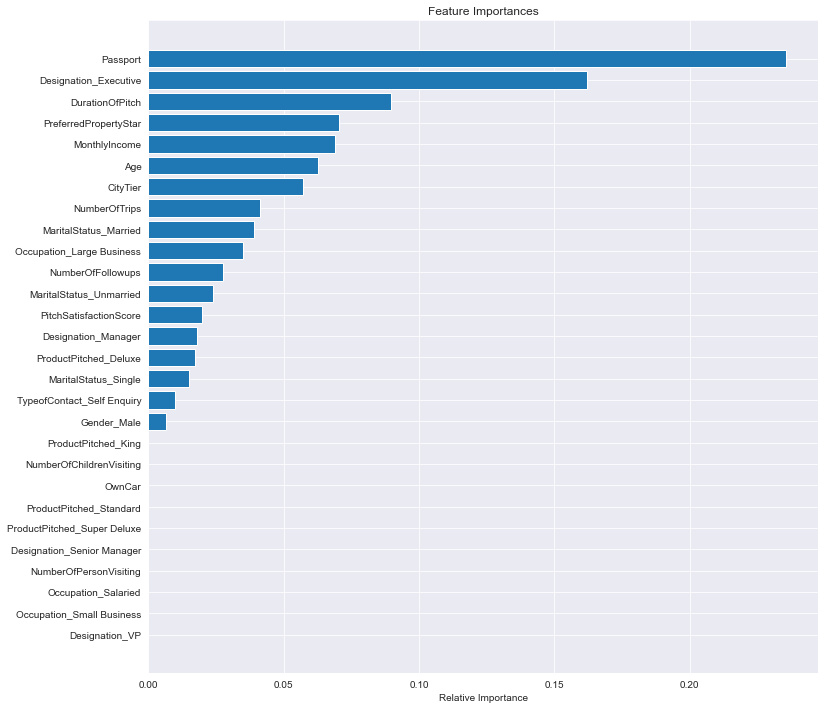

In [163]:
"""Examine the important features for the best performing model"""
feature_names = x_train.columns
importances = opt_dtree.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()